# TD1 – Kppv et réseaux de neurones pour la classification d'images

L’objectif de ce TD est d'implémenter un programme Python complet de classification d'images. Deux modèles de classification seront abordés : les k-plus-proches-voisins (kppv) et les réseaux de neurones (RNN). Les module numpy et scikit image seront utilisés, respectivement pour la manipulation des matrices et la manipulation des images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kppv import *
from skimage.feature import hog
from skimage import data, exposure
rng = np.random.default_rng()
from sklearn.metrics import confusion_matrix
import itertools
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.feature import local_binary_pattern
np.random.seed(1) # pour que l'exécution soit déterministe

# Réseaux de neurones

On s'intéresse désormais aux modèles de classification basé sur un réseau de neurones. On réutilise les fonctions de lecture et de découpage des données réalisées précédemment. Par ailleurs, commençons par définir les fonctions classiques calculatoires utilisées par la suite. Nous définissons la fonction sigmoid bien que nous n'utiliserons que les fonctions ReLU et softmax, respectivement pour les couches cachées et la couche de sortie. On définit également leur fonction backward correspondantes, qui nous permettront de réaliser la descente du gradient.

In [2]:
def softmax(Z):
    cache = Z
    Z -= np.max(Z)
    sm = (np.exp(Z) / np.sum(np.exp(Z), axis=0))
    return sm, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    assert (A.shape == Z.shape)
    cache = Z
    return A, cache

def softmax_backward(dA, cache):
    z = cache
    z -= np.max(z)
    s = (np.exp(z) / np.sum(np.exp(z), axis=0))
    dZ = dA * s * (1 - s)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    # When z <= 0, we set dz to 0 as well.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

## Initialisation
On commence par définir une fonction, qui, à partir d'une liste contenant les dimensions des différentes couches du réseau de neurones, initialisera les paramètres.
On peut noter ici que l'on réalise une initialisation des poids du réseau (matrice W) selon les principes Kaiming / MSRA Initialization. En effet, ce type d'initialisation est plus performante dans le cadre de l'utilisation de fonction ReLU pour les couches cachées du réseau. On initialise les biais (matrice b) comme étant un vecteur nul.

In [3]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)  # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

## Forward propagation
Ensuite on définit 3 fonctions nécessaires à la propagation en avant. Une fonction **linear_forward** effectuant les produits matriciels de la propagation en avant, puis une fonction **linear_activation_forward**, qui, utilisant **linear_forward** effectue la propagation d'une couche à une autre (produit matriciel + fonction d'activation). On a 3 options de fonctions : relu, sigmoid ou softmax. Par la suite nous utiliserons la fonctions **ReLU** pour les couches cachées, et la fonction **softmax** pour générer les probabilités sur la couche de sortie.
Enfin, **L_model_forward** permet de réaliser la propagation à travers toutes les couches, en utilisant **linear_activation_forward**. C'est le seul endroit où un boucle *for* est inévitable.

In [4]:
def batch_normalization(X):
    eps = 1e-7
    var = np.var(X, axis=0, keepdims=True)
    mean = np.mean(X, axis=0, keepdims=True)
    X_n = (X - mean)/np.sqrt(var + eps)
    return X_n

def linear_forward(A, W, b):
    A = batch_normalization(A)
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L + 1): # L+1 is pretty important ATTENTION
        A_prev = A
        Wl = parameters['W' + str(l)]
        bl = parameters['b' + str(l)]
        if l < L:
            A, cache = linear_activation_forward(A_prev, Wl, bl, activation="relu")
        else:
            AL, cache = linear_activation_forward(A_prev, Wl, bl, activation="softmax")
        caches.append(cache)
    return AL, caches


## Fonction de coût
On définit une fonction de coût. On a J = $\frac{-1}{m}$ $\sum_{i=1}^{m} y_i*log(al_i) $ où AL est le vecteur de sortie obtenue lors de la propagation en avant. C'est la fonction de coût dite de 'cross-entropy'

In [5]:
def compute_cost(AL, Y, activation_out, parameters, lambda_reg):
    m = Y.shape[1]
    L = len(parameters) // 2
    if activation_out == "sigmoid":
        cost = (-1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    elif activation_out == "softmax":
        cost = (-1 / m) * np.sum(Y * np.log(AL))
    reg_cost = 0
    for l in range(1, L):
        reg_cost += np.sum(parameters['W' + str(l)]**2)
    return cost+ lambda_reg*reg_cost/m

## Backward propagation
On définit 3 fonctions nécessaires à la backpropagation. Une fonction **linear_backward** effectuant les produits matriciels de la backpropagation, puis une fonction **linear_activation_backward**, qui, utilisant **linear_backward** propage la backpropagation en fonctione de la fonction d'activation de la couche (utilisation de la fonction backward adéquate).
Les différentes fonctions backward sont définies dans le fichier function.py, afin de ne pas alourdir le propos ici. Elles prennent toutes dA en argument, ainsi que le cache, et retournent dZ.
Enfin, **L_model_backward** permet de réaliser la backpropagation à travers toutes les couches, en utilisant **linear_activation_backward**. C'est le seul endroit où un boucle *for* est inévitable.

In [6]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, caches[L-1], activation="softmax")  # Softmax or sigmoid, in function of the need
    for l in reversed(range(L-1)):
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = linear_activation_backward(grads['dA' + str(l+1)], caches[l], activation="relu")
    return grads


## Mise à jour des paramètres
Suite à la backpropagation, on définit une fonction pour mettre à jour les paramètres en fonctions des gradients récupérés, des valeurs initiales des paramètres, ainsi que du learning_rate. Ce learning_rate est un hyper-paramètre qu'il nous faudra ajuster par la suite

In [7]:
def adam_grad(grad, beta1, beta2, n_iter): #n_iter is the number of the iteration/ epoch ?
    first_moment = 0
    second_moment = 0
    first_moment = beta1 * first_moment+(1-beta1)*grad
    second_moment = beta2* second_moment + (1-beta2)*grad*grad
    first_unbias = first_moment / (1-beta1**n_iter)
    second_unbias = second_moment / (1-beta2**n_iter)
    return (first_unbias, second_unbias)

def learning_rate_decay(learning_rate_0, n_epoch, N_epoch):
    learning_rate_n = learning_rate_0*(1+np.cos(np.pi*n_epoch/N_epoch))/2  # Commence à 1
    return learning_rate_n


def update_parameters(params, grads, learning_rate, n_epoch, N_epoch, beta1, beta2, learning_r_decay=True, adam=True):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network
    if learning_r_decay:
        learning_rate_cur = learning_rate_decay(learning_rate, n_epoch, N_epoch)
    else:
        learning_rate_cur = learning_rate
    for l in range(1,L+1):
        if adam:
            first_unbias_w, second_unbias_w = adam_grad(grads['dW' + str(l)], beta1, beta2, n_epoch)
            parameters['W' + str(l)] = parameters['W' + str(l)] -learning_rate*first_unbias_w / (np.sqrt(second_unbias_w)+ 1e-7)
            first_unbias_l, second_unbias_l = adam_grad(grads['db' + str(l)], beta1, beta2, n_epoch)
            parameters['b' + str(l)] = parameters['b' + str(l)] -learning_rate*first_unbias_l / (np.sqrt(second_unbias_l)+ 1e-7)
        else:
            parameters['W' + str(l)] = parameters['W' + str(l)] -learning_rate_cur*grads['dW' + str(l)]
            parameters['b' + str(l)] = parameters['b' + str(l)] -learning_rate_cur*grads['db' + str(l)]
    return parameters

## Modèle complet

In [8]:
# L_layer_model
def L_layer_model(X, Y, parameters, learning_rate, lambda_reg, n_epoch, N_epoch, beta1, beta2, prev_cost,
                  learning_r_dec, adam):

    costn_1 = prev_cost
    AL, caches = L_model_forward(X, parameters)
    cost = compute_cost(AL, Y, 'softmax', parameters, lambda_reg)
    grads = L_model_backward(AL, Y, caches)
    parameters = update_parameters(parameters, grads, learning_rate, n_epoch, N_epoch, beta1, beta2, learning_r_dec, adam)

    if costn_1 < cost:
        print("Error, Alpha parameter to lessen")

    return parameters, cost

## Fonction d'évaluation de la performance

In [9]:
def evaluate_prediction(Ypred, Ytest):
    tot_true = np.sum(Ytest==np.array(np.argmax(Ypred, axis=0)))
    return tot_true/Ytest.size

## Tracé de l'apprentissage

In [10]:
def plot_loss_function(cost):
    n_iter = len(cost)
    iter = np.arange(1, n_iter+1)
    plt.plot(iter, cost)
    plt.title("Cost function")
    plt.show()
    
def plot_accuracy(train_accu, test_accu):
    n_iter = len(train_accu)
    iter = np.arange(1, n_iter+1)
    plt.plot(iter, train_accu, "b--", label="Training accuracy")
    plt.plot(iter, test_accu, "r--", label="Test accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()
    

In [125]:
# Training the model
def preprocessing(data, labels):
    data = (data - np.mean(data, axis=0, keepdims=True))/np.std(data, axis=0, keepdims=True)
    Xapp, Yapp, Xtest, Ytest = split_data(data, labels)
    X_t = Xapp.T
    Y_t = np.array([Yapp])
    X_te = Xtest.T
    Y_te = np.array([Ytest])
    return (X_t, Y_t, X_te, Y_te)

def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(inputs.shape[1])
    np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[1] - batchsize + 1, batchsize):
        batch_index = indices[start_idx:start_idx + batchsize]
        yield inputs[:,batch_index], targets[:,batch_index]
        
def one_hot_encoding(Y_vect):
    uniques = np.unique(Y_vect)
    n_y = len(uniques)
    Y_one_hot = np.zeros((n_y, Y_vect.shape[1]))
    for i in range(n_y):
        Y_one_hot[i,:] = (Y_vect == uniques[i])
    return Y_one_hot
    
def NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers, N_epoch, batch_size, learning_rate, lambda_reg, 
              beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True):
    n_x, m = X_train.shape[0], X_train.shape[1]
    n_y = len(np.unique(Y_train))
    costs = []
    train_accu = []
    test_accu = []
    layers_dims = [n_x] + hidden_layers + [n_y] # 0.0025 good for [50,25]  # Try 0.0001 bcs 0.0005 not working at 1500 it.
    parameters = initialize_parameters_deep(layers_dims)
    cost = 0
    for k in range(1,N_epoch+1):
        for batch in iterate_minibatches(X_train, Y_train, batch_size):
            X_b, Y_b = batch
            Y_b_train = one_hot_encoding(Y_b)
            
            parameters, cost = L_layer_model(X_b, Y_b_train, parameters, learning_rate, lambda_reg,
                                   k, N_epoch, beta1, beta2, cost, learning_r_dec, adam)
            costs.append(cost)
            
            pred_train = evaluate_prediction(L_model_forward(X_b,parameters)[0], Y_b)
            pred_test = evaluate_prediction(L_model_forward(X_test_clean,parameters)[0], Y_test_clean)
            train_accu.append(pred_train)
            test_accu.append(pred_test)
            print(cost)
        plot_loss_function(costs)
    print(f'NN accuracy on training set \033[1m{pred_train:.3%}\033[0m')
    print(f'NN accuracy on test set \033[1m{pred_test:.3%}\033[0m')
    plot_accuracy(train_accu, test_accu)

Error, Alpha parameter to lessen
3.060684621046492
2.7067328804536546
2.548672148457718
2.503443256539822
2.4094718958639403
2.3196869640831888
Error, Alpha parameter to lessen
2.331448739982937
2.1053310254718363
Error, Alpha parameter to lessen
2.2907620501493837
Error, Alpha parameter to lessen
2.2951442481539224
2.25989638673199
2.208594681744156
2.2080138163617153
2.126477138343891
2.09259520149926


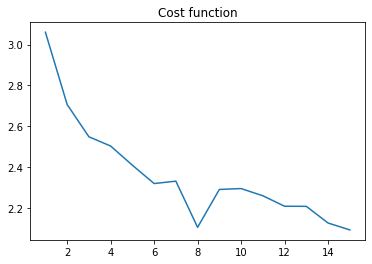

2.0456078442712338
1.9581666439195895
Error, Alpha parameter to lessen
1.992010861201712
1.9524277687338376
Error, Alpha parameter to lessen
2.0332368681420596
1.9699147155419867
1.9168736510156938
Error, Alpha parameter to lessen
2.0069081641773043
1.9780601171658607
1.8312844119066414
Error, Alpha parameter to lessen
1.8536463425455916
Error, Alpha parameter to lessen
1.8991212897698027
Error, Alpha parameter to lessen
1.9612346279627564
1.9091290709303366
Error, Alpha parameter to lessen
1.9386463648625765


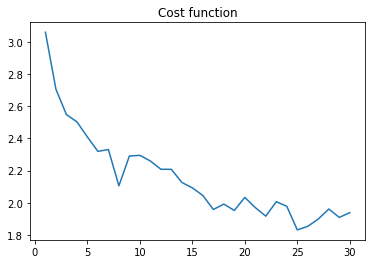

1.8344213977310573
1.7767841754377613
Error, Alpha parameter to lessen
1.7829978784727316
1.7365714348790633
Error, Alpha parameter to lessen
1.8494257324682835
1.8448748275956992
1.8153060673340993
1.807451114715565
1.7844515017145983
Error, Alpha parameter to lessen
1.82744885440944
1.730584022914573
Error, Alpha parameter to lessen
1.7930544034660962
Error, Alpha parameter to lessen
1.8247308689244128
Error, Alpha parameter to lessen
1.8569963644987664
1.7272373322207164


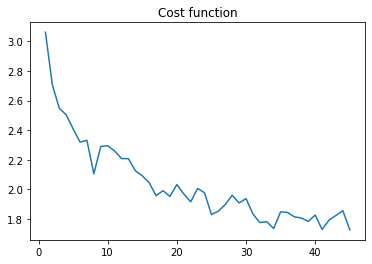

1.6565618305547665
1.6556342416236243
Error, Alpha parameter to lessen
1.71370563177729
Error, Alpha parameter to lessen
1.7592146931621744
1.7492667722116608
1.7360359884196
1.7304547447861416
1.6800848358653129
Error, Alpha parameter to lessen
1.7600706607866683
1.636940638034456
Error, Alpha parameter to lessen
1.7080959589972882
1.6992224247930867
Error, Alpha parameter to lessen
1.7086105643349832
1.6914847019079833
Error, Alpha parameter to lessen
1.8021883134582404


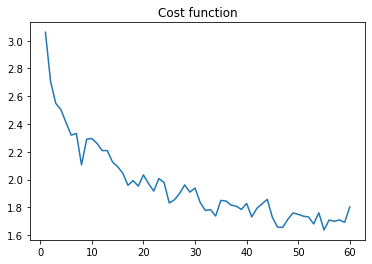

1.575030468437853
Error, Alpha parameter to lessen
1.5920829510010623
Error, Alpha parameter to lessen
1.627185152616038
Error, Alpha parameter to lessen
1.6870642932394655
1.6613554066587963
1.6417027551307801
Error, Alpha parameter to lessen
1.7369893357358976
1.598985775043954
Error, Alpha parameter to lessen
1.6695505739014027
1.6472840153060104
Error, Alpha parameter to lessen
1.663646775897915
Error, Alpha parameter to lessen
1.70037109358699
1.6416351117020043
Error, Alpha parameter to lessen
1.679008897375207
1.6736074414338404


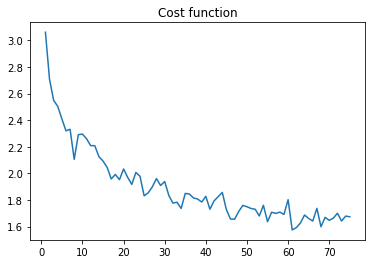

1.5920534811246236
1.521066126405331
Error, Alpha parameter to lessen
1.6390284532936799
Error, Alpha parameter to lessen
1.6527474766125683
1.5173297310687144
Error, Alpha parameter to lessen
1.563984245054402
Error, Alpha parameter to lessen
1.5686095508607285
Error, Alpha parameter to lessen
1.614621221897038
Error, Alpha parameter to lessen
1.6888645200299344
1.6003344642123132
1.5994686292543085
Error, Alpha parameter to lessen
1.601019357186595
1.5789453626726748
Error, Alpha parameter to lessen
1.6146050570920172
1.6136968012759678


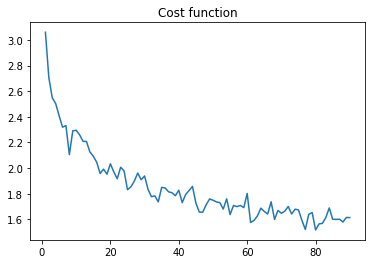

1.549635175080613
Error, Alpha parameter to lessen
1.6266979706605027
1.5623357482747464
1.5311079568404065
Error, Alpha parameter to lessen
1.5492198186884056
1.5269222427365743
Error, Alpha parameter to lessen
1.5758157533807422
1.554536774320011
1.5084892709951665
Error, Alpha parameter to lessen
1.5809184875587452
1.5462309077392826
Error, Alpha parameter to lessen
1.6039277012639224
1.5864496831472166
1.5220635083076168
Error, Alpha parameter to lessen
1.6009038730363332


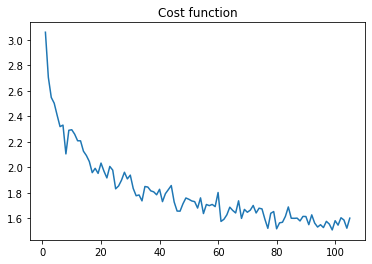

1.4231723358433919
Error, Alpha parameter to lessen
1.5075539922176648
1.5020567386003432
Error, Alpha parameter to lessen
1.5295627117890398
1.5129218953269257
1.5076984315064303
Error, Alpha parameter to lessen
1.55432526987803
Error, Alpha parameter to lessen
1.6150252123388644
1.4814743451898162
Error, Alpha parameter to lessen
1.4979095396355637
Error, Alpha parameter to lessen
1.5693417374432512
1.484258662035147
Error, Alpha parameter to lessen
1.6243199602874385
1.5590527844178748
1.5295550046808175


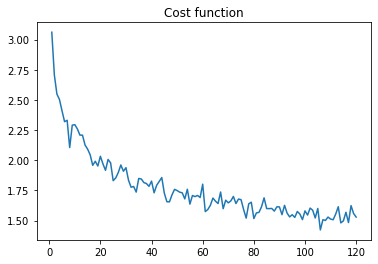

1.4578861760968636
Error, Alpha parameter to lessen
1.483770998132508
Error, Alpha parameter to lessen
1.5291126997321496
1.4416154977952484
Error, Alpha parameter to lessen
1.5070616127012844
Error, Alpha parameter to lessen
1.5072101585573532
Error, Alpha parameter to lessen
1.5157772785287655
1.5063045409624514
1.409675288947452
Error, Alpha parameter to lessen
1.5410837961750414
1.4970883254001577
Error, Alpha parameter to lessen
1.590154298303979
1.522959489080983
1.4635087930926978
Error, Alpha parameter to lessen
1.5500218981056266


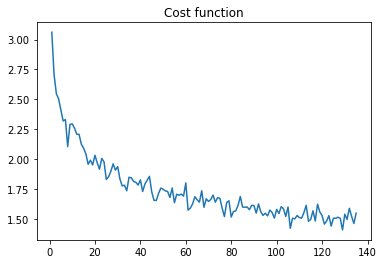

1.518863258064029
1.4464156648411954
1.4363980443589477
1.4263535529779692
Error, Alpha parameter to lessen
1.4347494789047568
Error, Alpha parameter to lessen
1.5253939102527212
1.4867671625695134
1.477042378425228
Error, Alpha parameter to lessen
1.5089058413831082
Error, Alpha parameter to lessen
1.5528452153132652
1.429124806693883
Error, Alpha parameter to lessen
1.4795978698594605
1.4737325239972394
Error, Alpha parameter to lessen
1.4845912010946811
1.4515929939827938


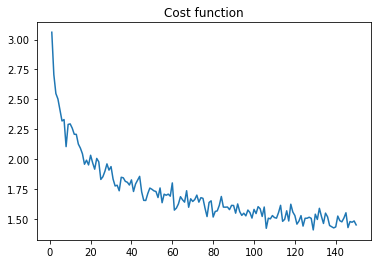

1.4140289978853953
Error, Alpha parameter to lessen
1.439411717098513
1.3949020893436945
Error, Alpha parameter to lessen
1.4488691483016076
1.4399170058148296
Error, Alpha parameter to lessen
1.4707473694900957
1.4101056314409792
Error, Alpha parameter to lessen
1.5309662951964027
1.5078828983510906
Error, Alpha parameter to lessen
1.5616914717803738
1.4668403676871549
1.4175725971758757
1.4139410910445451
Error, Alpha parameter to lessen
1.4494091511927585
1.4010519205059002


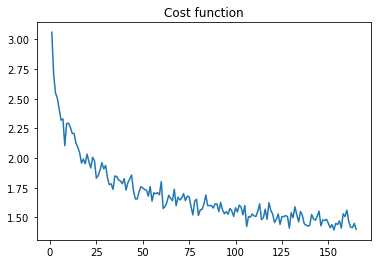

1.3625516638267434
Error, Alpha parameter to lessen
1.4281093615575942
Error, Alpha parameter to lessen
1.5155480243375024
1.4309731027292538
1.3491534498142927
Error, Alpha parameter to lessen
1.4875251571450894
1.4472755916709186
Error, Alpha parameter to lessen
1.454856451325891
1.3859443817562667
Error, Alpha parameter to lessen
1.452366510818882
Error, Alpha parameter to lessen
1.4782644750829592
1.4356818867523438
Error, Alpha parameter to lessen
1.4787638259495866
1.4075168234556306
Error, Alpha parameter to lessen
1.4598658084802911


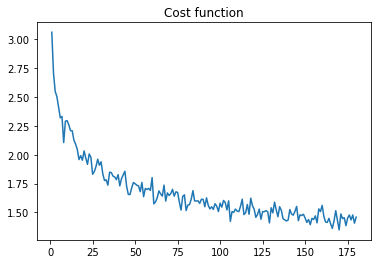

1.4107268526063002
1.3372906468394905
Error, Alpha parameter to lessen
1.4551947841273227
1.4232709590630874
Error, Alpha parameter to lessen
1.4455775795797754
1.347846557702806
Error, Alpha parameter to lessen
1.4342700656003153
Error, Alpha parameter to lessen
1.445066131050573
1.4298866299975335
Error, Alpha parameter to lessen
1.462169702469358
1.4004816160866487
Error, Alpha parameter to lessen
1.4145492253406975
Error, Alpha parameter to lessen
1.47061337126146
1.4052638212153428
1.3898987216644116


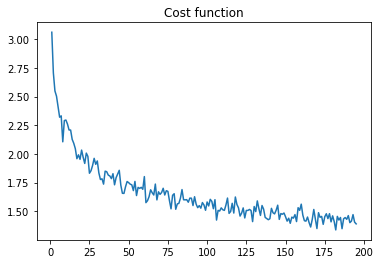

1.3695268831910108
1.3586498443455737
Error, Alpha parameter to lessen
1.4236649992099704
1.4023408935743857
Error, Alpha parameter to lessen
1.431554947393239
1.4034617626788062
Error, Alpha parameter to lessen
1.4109236103719585
1.383655483140164
Error, Alpha parameter to lessen
1.4152150139633584
Error, Alpha parameter to lessen
1.4274479239230957
1.3745069101599885
Error, Alpha parameter to lessen
1.3950295285569196
Error, Alpha parameter to lessen
1.4302703917392097
1.3493744257635327
Error, Alpha parameter to lessen
1.4582525032696674


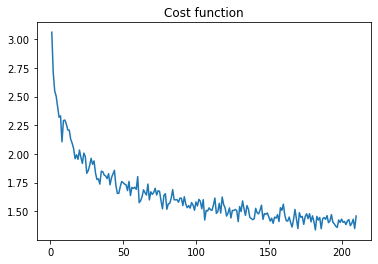

1.3427445640885105
Error, Alpha parameter to lessen
1.4621611822079468
1.3443475964168732
Error, Alpha parameter to lessen
1.3507928761043189
Error, Alpha parameter to lessen
1.4376487642291302
1.3491743617394318
1.3159583935345027
Error, Alpha parameter to lessen
1.4482466972374193
1.3812201737545708
1.3197660739271773
Error, Alpha parameter to lessen
1.3773091145003802
Error, Alpha parameter to lessen
1.3825886699394392
Error, Alpha parameter to lessen
1.4502040575506383
1.437489261794537
1.3791134602855466


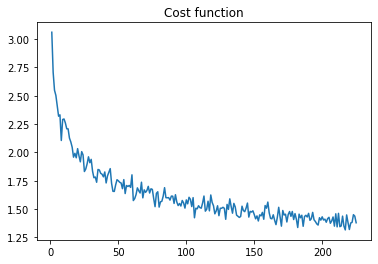

1.3391817242904713
Error, Alpha parameter to lessen
1.3442362893171822
Error, Alpha parameter to lessen
1.4093178761930534
1.3836726938849642
1.3284701582027156
1.293565473499779
Error, Alpha parameter to lessen
1.3866701020760763
Error, Alpha parameter to lessen
1.4074857377953536
1.3234893084865
Error, Alpha parameter to lessen
1.360327150292559
Error, Alpha parameter to lessen
1.3746102840428116
Error, Alpha parameter to lessen
1.3933118300544178
Error, Alpha parameter to lessen
1.443823653997832
1.341186760121262
Error, Alpha parameter to lessen
1.3981972366043818


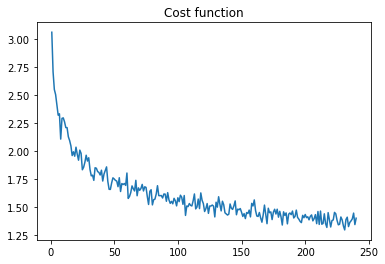

1.3540847343547904
1.3097071014096728
Error, Alpha parameter to lessen
1.4020435597856749
1.2646835847087787
Error, Alpha parameter to lessen
1.2847427487311143
Error, Alpha parameter to lessen
1.3500449051658805
Error, Alpha parameter to lessen
1.3714141291179436
Error, Alpha parameter to lessen
1.3724747294940673
Error, Alpha parameter to lessen
1.374121697906363
1.3529021974211954
Error, Alpha parameter to lessen
1.3835326388218765
1.3668509980268408
1.3592753058075884
1.3536746073968897
Error, Alpha parameter to lessen
1.4174663980475328


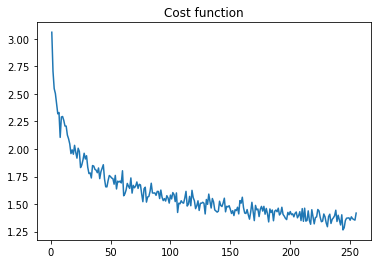

1.389225574420954
1.3044997890398953
Error, Alpha parameter to lessen
1.309121402419886
1.304550266423015
Error, Alpha parameter to lessen
1.319139992086358
Error, Alpha parameter to lessen
1.4187984623114989
1.3981399299714778
1.3024301213285299
Error, Alpha parameter to lessen
1.370573410918583
1.2979808449509285
Error, Alpha parameter to lessen
1.318396104210092
Error, Alpha parameter to lessen
1.350491122888317
Error, Alpha parameter to lessen
1.3774266684975784
Error, Alpha parameter to lessen
1.3878183749676871
1.3395364537226575


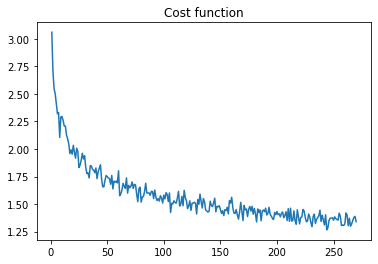

Error, Alpha parameter to lessen
1.3797085483968636
1.2823503855703107
Error, Alpha parameter to lessen
1.2935637527892885
Error, Alpha parameter to lessen
1.3297816512059562
1.2611783000460297
Error, Alpha parameter to lessen
1.3075782827902254
Error, Alpha parameter to lessen
1.3363509163720146
Error, Alpha parameter to lessen
1.34492307645303
1.3295449828514985
Error, Alpha parameter to lessen
1.4163141318615584
1.3078876278346483
Error, Alpha parameter to lessen
1.3427149439396455
1.3183438311649978
Error, Alpha parameter to lessen
1.371276376729079
1.351642925374371


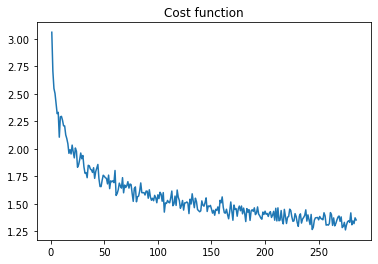

1.2289338681970066
Error, Alpha parameter to lessen
1.3200973086294518
1.2922228646126004
Error, Alpha parameter to lessen
1.3575521127469456
1.2700968385592328
Error, Alpha parameter to lessen
1.3548668878754453
1.326820579257097
Error, Alpha parameter to lessen
1.3778509368912977
1.3022275700290311
Error, Alpha parameter to lessen
1.3143562913919862
1.2961098460972045
Error, Alpha parameter to lessen
1.3736906513958334
Error, Alpha parameter to lessen
1.3981182879994798
1.292167585556548
1.2816792968399822


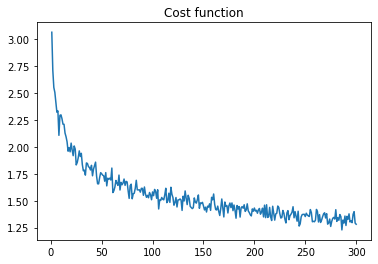

Error, Alpha parameter to lessen
1.3103057409604881
1.2445318087428185
Error, Alpha parameter to lessen
1.3251339109059839
Error, Alpha parameter to lessen
1.3460022028194023
1.2958202506377137
Error, Alpha parameter to lessen
1.327413096777136
1.2917012672724386
Error, Alpha parameter to lessen
1.3183711729333443
Error, Alpha parameter to lessen
1.324930525319585
1.2998474747660698
1.2248364109902588
Error, Alpha parameter to lessen
1.2884393098225915
Error, Alpha parameter to lessen
1.3833908865015931
1.3083244156888199
Error, Alpha parameter to lessen
1.3536415634774697


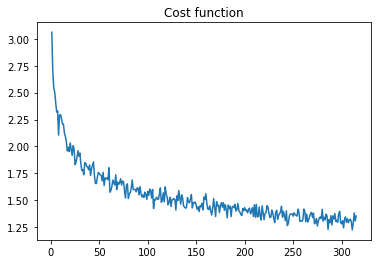

1.2834803226838793
Error, Alpha parameter to lessen
1.2860109262880512
1.2440611268924475
Error, Alpha parameter to lessen
1.2605600269580681
1.2585372085956157
Error, Alpha parameter to lessen
1.321304774957651
Error, Alpha parameter to lessen
1.3433541900608021
1.2736883253381759
1.243781656254185
Error, Alpha parameter to lessen
1.2943885685755043
1.28631089887033
Error, Alpha parameter to lessen
1.3833448475561376
1.3205555879836521
1.30249491916405
Error, Alpha parameter to lessen
1.362127110660909


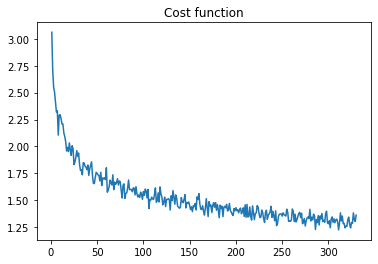

1.2322227083245774
Error, Alpha parameter to lessen
1.2567900964330592
Error, Alpha parameter to lessen
1.2636981566682353
1.246854300877711
Error, Alpha parameter to lessen
1.382298419357334
1.2423744631691613
Error, Alpha parameter to lessen
1.3095977956947533
1.2837041047379723
1.2356554441600762
Error, Alpha parameter to lessen
1.3013792606766905
1.23859233807178
Error, Alpha parameter to lessen
1.283862724989665
Error, Alpha parameter to lessen
1.3262268283156984
Error, Alpha parameter to lessen
1.3326820083729007
1.3177446339817462


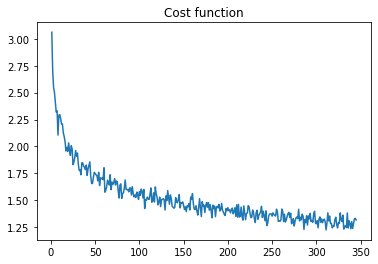

1.301419975588389
1.2659044291618562
1.2524749869408935
1.248083069488998
Error, Alpha parameter to lessen
1.3184618049368837
1.285814352462663
1.2679590255318833
Error, Alpha parameter to lessen
1.285768284105581
1.2640410526528905
1.2620889636325863
Error, Alpha parameter to lessen
1.2787058662070245
Error, Alpha parameter to lessen
1.3038208003252059
1.2323458050298992
Error, Alpha parameter to lessen
1.264722501318441
1.2623154035035318


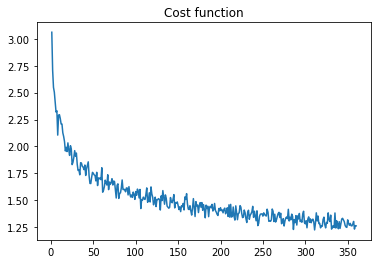

1.2138004437238248
Error, Alpha parameter to lessen
1.234088094920602
Error, Alpha parameter to lessen
1.2764557118060946
1.2697181972992726
Error, Alpha parameter to lessen
1.2882667942866866
1.2565863365947707
Error, Alpha parameter to lessen
1.3702641462571898
1.1564480493110028
Error, Alpha parameter to lessen
1.2896263066896512
1.2581981998406226
Error, Alpha parameter to lessen
1.2743625204764208
1.2555399790043391
Error, Alpha parameter to lessen
1.3005965224504568
1.2509394406452379
Error, Alpha parameter to lessen
1.2893259358957225


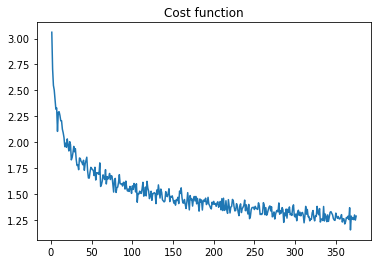

1.2592852873720588
Error, Alpha parameter to lessen
1.3049675376208827
1.2173915368646802
1.2096793838940505
Error, Alpha parameter to lessen
1.2820862930803163
1.2607949038678892
Error, Alpha parameter to lessen
1.3379817289848048
1.2711234638147741
1.2550554916477528
1.2490341101529063
1.2454569876439732
Error, Alpha parameter to lessen
1.2687097525358024
1.2249926064845118
1.2214265566808196
1.218595933877719


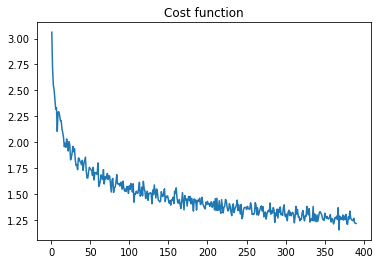

1.1817345686706413
Error, Alpha parameter to lessen
1.2407709300632817
1.238440149926509
Error, Alpha parameter to lessen
1.261967700367176
1.2289363458586278
Error, Alpha parameter to lessen
1.253021515471375
1.2054064762692773
Error, Alpha parameter to lessen
1.2297291336796898
Error, Alpha parameter to lessen
1.2483985838058562
Error, Alpha parameter to lessen
1.2818138996196247
Error, Alpha parameter to lessen
1.3059918411609273
1.256711855865024
Error, Alpha parameter to lessen
1.2783711189115363
1.2528786792935815
1.2252665161438026


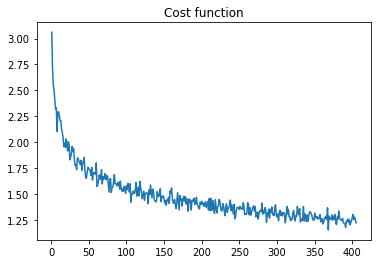

Error, Alpha parameter to lessen
1.2642661749566075
1.1671548419945914
Error, Alpha parameter to lessen
1.2123828456246284
Error, Alpha parameter to lessen
1.2933028188350348
1.2910004124680392
1.2107250918719314
1.1713381761637673
Error, Alpha parameter to lessen
1.2650079683193756
Error, Alpha parameter to lessen
1.2835643623535749
Error, Alpha parameter to lessen
1.2930355420057014
1.1961866873422211
1.1906828341462654
Error, Alpha parameter to lessen
1.1954481615751495
Error, Alpha parameter to lessen
1.2665477222908152
1.2439483208517366


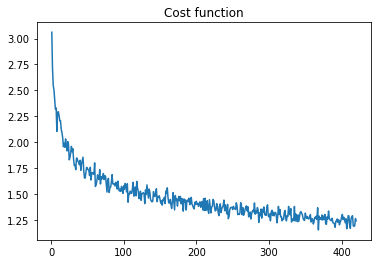

1.2320833512550704
1.2240728627353243
1.2196436206972678
1.1851595878962824
1.165642581017876
Error, Alpha parameter to lessen
1.1777808535906298
Error, Alpha parameter to lessen
1.2587298435809746
Error, Alpha parameter to lessen
1.2648939990101598
1.1918392206397186
Error, Alpha parameter to lessen
1.215291911449132
Error, Alpha parameter to lessen
1.3100003473017205
1.2050166215088816
Error, Alpha parameter to lessen
1.3098101681784207
1.2198398561486812
Error, Alpha parameter to lessen
1.2209616221950903


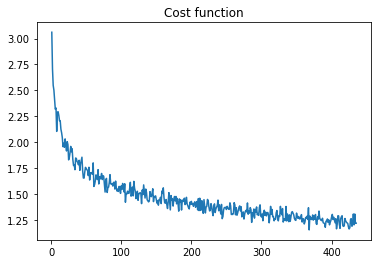

1.1761521188268822
Error, Alpha parameter to lessen
1.2562463248114228
1.1886837893925732
1.182754637833201
Error, Alpha parameter to lessen
1.1948082176330483
Error, Alpha parameter to lessen
1.2088319402849785
1.1674158978435125
Error, Alpha parameter to lessen
1.2208780248642213
Error, Alpha parameter to lessen
1.288277952192092
1.266817495570086
1.2098599784476771
1.2045862707139627
1.186424951104375
Error, Alpha parameter to lessen
1.2520616531971935
1.2444441326312434


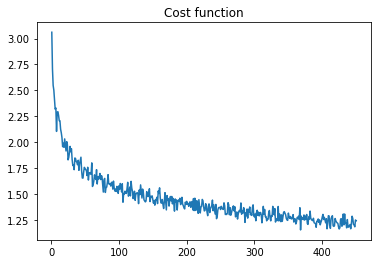

1.179042962997098
1.1491671733288942
Error, Alpha parameter to lessen
1.1787235721783804
Error, Alpha parameter to lessen
1.1874985271528065
Error, Alpha parameter to lessen
1.20976245036474
1.156968147288926
1.1115814495813847
Error, Alpha parameter to lessen
1.1803543924172626
Error, Alpha parameter to lessen
1.2325710104470429
1.2308867277179236
Error, Alpha parameter to lessen
1.2378693873227984
1.2216184506126093
Error, Alpha parameter to lessen
1.3045171487837062
1.2777685818421662
Error, Alpha parameter to lessen
1.3002722458690545


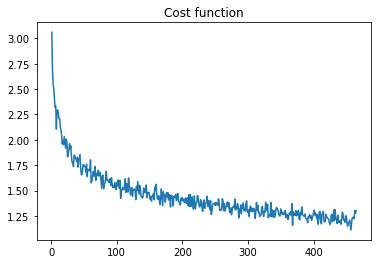

1.2239586902338462
1.1938319810046953
Error, Alpha parameter to lessen
1.2529932499259804
1.2142621876226944
1.206648952561857
1.1782244930989338
1.1679221203619667
Error, Alpha parameter to lessen
1.2658084975225965
1.145823016519023
Error, Alpha parameter to lessen
1.195328233822972
1.1514561266008871
Error, Alpha parameter to lessen
1.1698721998069506
Error, Alpha parameter to lessen
1.2212566876542805
Error, Alpha parameter to lessen
1.2318143776811659
1.166055653889503


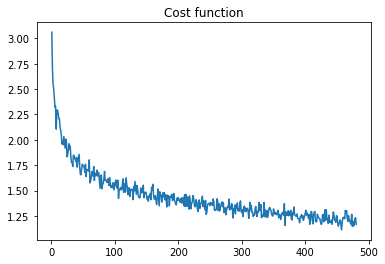

1.1465655809635495
Error, Alpha parameter to lessen
1.166317212795422
Error, Alpha parameter to lessen
1.2201335786840979
1.1379290074073727
Error, Alpha parameter to lessen
1.1619261437347037
Error, Alpha parameter to lessen
1.2352310965214224
1.1467757184383485
Error, Alpha parameter to lessen
1.2051894519364368
Error, Alpha parameter to lessen
1.2348733254429325
1.2260553233514464
Error, Alpha parameter to lessen
1.2325013777988811
1.1823099995608268
Error, Alpha parameter to lessen
1.2272763521348988
1.152516907884321
Error, Alpha parameter to lessen
1.1561182510331751


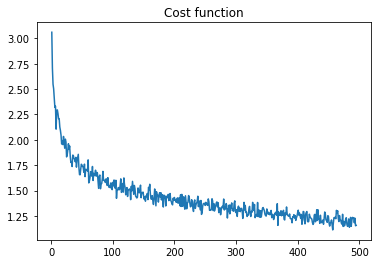

1.1463847887085086
1.1453700492163825
1.12732490732937
Error, Alpha parameter to lessen
1.1622057530488863
Error, Alpha parameter to lessen
1.2526733474585356
1.147918495395078
Error, Alpha parameter to lessen
1.1770769782277757
Error, Alpha parameter to lessen
1.2611175799874883
1.1975321126157672
Error, Alpha parameter to lessen
1.2230367827840276
1.1391980838192626
Error, Alpha parameter to lessen
1.223437555334187
1.2134101029488893
1.1445119870486538
Error, Alpha parameter to lessen
1.1869254164543213


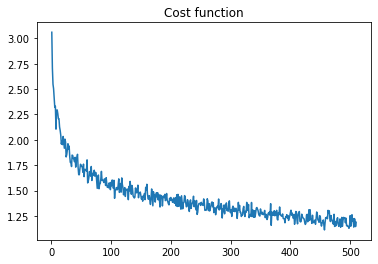

1.1624973091014223
1.1404615644681013
1.1153975491927075
Error, Alpha parameter to lessen
1.1883063468457864
Error, Alpha parameter to lessen
1.2200215019347405
1.1632318683009044
1.158749909946356
Error, Alpha parameter to lessen
1.21054175393758
Error, Alpha parameter to lessen
1.232335943437531
1.1255129371295316
Error, Alpha parameter to lessen
1.1704655733919385
1.105632406238571
Error, Alpha parameter to lessen
1.1505108164269
Error, Alpha parameter to lessen
1.2333981946426944
1.1662532373978605


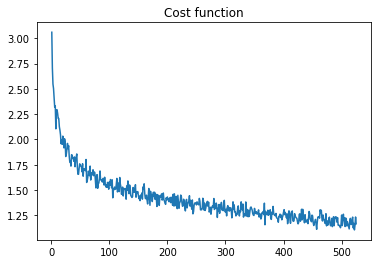

1.0506377042870072
Error, Alpha parameter to lessen
1.1362295037005354
Error, Alpha parameter to lessen
1.1654052875051575
1.1555851576191305
1.103187680263722
Error, Alpha parameter to lessen
1.1695946713402097
Error, Alpha parameter to lessen
1.2313493436467016
1.2246708676457314
1.1724765581539824
1.1560371630298025
Error, Alpha parameter to lessen
1.211958839656134
1.2087145541149895
1.1088327423867383
Error, Alpha parameter to lessen
1.1599264855655933
Error, Alpha parameter to lessen
1.1795036175202973


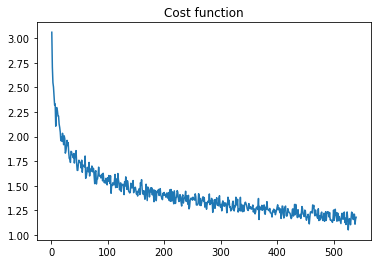

1.0749347380783734
Error, Alpha parameter to lessen
1.1708171631519835
1.1194712595298595
1.0847564445453821
Error, Alpha parameter to lessen
1.157206459174035
1.1435012589868594
1.116969895742748
Error, Alpha parameter to lessen
1.1812975267973074
Error, Alpha parameter to lessen
1.2052665934573368
1.1842107723312154
1.1681450676222276
1.1595404466385641
Error, Alpha parameter to lessen
1.2283690622623418
1.186115588093112
1.1480704785446036


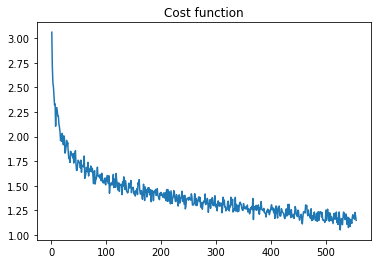

1.125337988571342
Error, Alpha parameter to lessen
1.1497835552600624
1.0374820496256163
Error, Alpha parameter to lessen
1.1229893568077784
1.1081254669114327
1.0987381402254761
Error, Alpha parameter to lessen
1.2094219367600247
1.1286529679878752
Error, Alpha parameter to lessen
1.15277324086647
Error, Alpha parameter to lessen
1.1695769034524794
Error, Alpha parameter to lessen
1.170530587346894
Error, Alpha parameter to lessen
1.185860892459093
Error, Alpha parameter to lessen
1.1952001808371342
Error, Alpha parameter to lessen
1.195465075793702
1.109579399672168


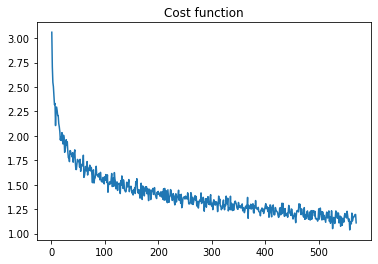

1.087306380250896
Error, Alpha parameter to lessen
1.0895845887329372
Error, Alpha parameter to lessen
1.1499062878900173
1.0892784014236614
Error, Alpha parameter to lessen
1.1596627485674809
1.1012357570508438
Error, Alpha parameter to lessen
1.1661341081149905
1.1324336305489064
Error, Alpha parameter to lessen
1.1487666288957743
Error, Alpha parameter to lessen
1.1532987978031484
Error, Alpha parameter to lessen
1.2079740628890179
1.159861749963032
1.1263604195613124
Error, Alpha parameter to lessen
1.1563280643358766
1.095999880209509


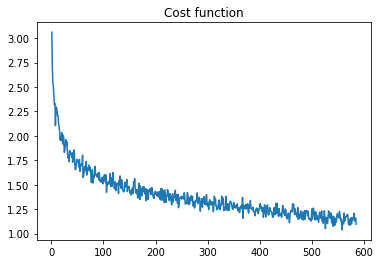

1.0520389904943575
Error, Alpha parameter to lessen
1.0903507503585372
Error, Alpha parameter to lessen
1.1142767546169756
1.0921767470668633
Error, Alpha parameter to lessen
1.168213233788928
1.1191627940656728
Error, Alpha parameter to lessen
1.1680278111446092
1.1574232466308867
1.140592278289004
Error, Alpha parameter to lessen
1.157415429978048
Error, Alpha parameter to lessen
1.2395992809282939
1.0995801181695877
Error, Alpha parameter to lessen
1.1146535424347501
1.0787974681110983
Error, Alpha parameter to lessen
1.1290922609501488


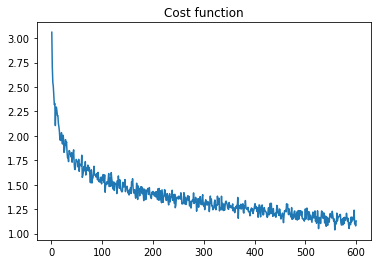

1.1023625474123013
1.0928517815540977
Error, Alpha parameter to lessen
1.1240944889150006
1.0876177019540019
Error, Alpha parameter to lessen
1.1833775946205667
1.0047039664091286
Error, Alpha parameter to lessen
1.1786807341874073
1.1093799462896985
1.0993226262450921
Error, Alpha parameter to lessen
1.1124526592048918
Error, Alpha parameter to lessen
1.1452653798271488
Error, Alpha parameter to lessen
1.1468544799988634
1.1029313350149437
Error, Alpha parameter to lessen
1.1340291584206033
1.1302794651312746


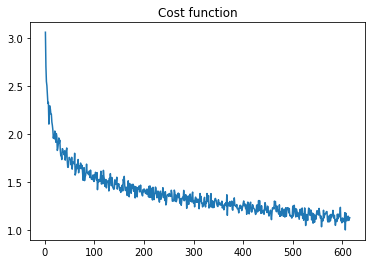

1.068993985400941
Error, Alpha parameter to lessen
1.1464061397232208
1.0035233031785673
Error, Alpha parameter to lessen
1.089688533518952
1.0796053580860572
Error, Alpha parameter to lessen
1.0960598885812607
1.0381534240461883
Error, Alpha parameter to lessen
1.162149221855614
Error, Alpha parameter to lessen
1.185645667714755
1.1099880086453595
Error, Alpha parameter to lessen
1.1656297619131322
Error, Alpha parameter to lessen
1.1787679175257209
1.0753713180402913
Error, Alpha parameter to lessen
1.0986597911368878
Error, Alpha parameter to lessen
1.1951046427569174


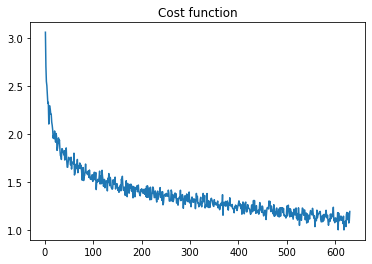

1.0580293209132667
1.0549823595131187
Error, Alpha parameter to lessen
1.186644641206453
0.9773485009055836
Error, Alpha parameter to lessen
1.1725944679531384
1.1448282399168601
1.13458841919963
1.063476735356054
Error, Alpha parameter to lessen
1.0673644922587662
Error, Alpha parameter to lessen
1.1001986173665625
Error, Alpha parameter to lessen
1.1057647581837313
Error, Alpha parameter to lessen
1.1522953178817879
1.1025516070007868
1.0858225658907144
1.061663640010134


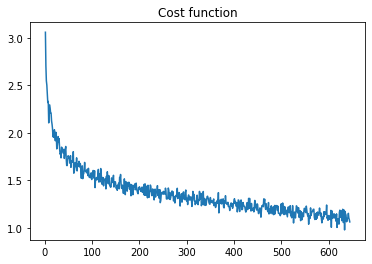

1.0479828609021458
Error, Alpha parameter to lessen
1.119153728391
Error, Alpha parameter to lessen
1.1270472510428862
1.1084817738318815
1.0644053331335341
Error, Alpha parameter to lessen
1.0725098039991712
Error, Alpha parameter to lessen
1.0898239906049203
Error, Alpha parameter to lessen
1.1389301639152964
1.1056171847881153
Error, Alpha parameter to lessen
1.1121428271908886
Error, Alpha parameter to lessen
1.1136699879840724
Error, Alpha parameter to lessen
1.1574143074306846
1.1220761129616195
0.9783450089174578
Error, Alpha parameter to lessen
1.015846441635697


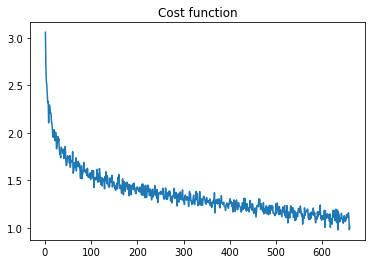

Error, Alpha parameter to lessen
1.075667009590636
Error, Alpha parameter to lessen
1.144584303808017
1.0901848246886683
1.075100099986082
Error, Alpha parameter to lessen
1.1521470148794555
1.053254156827051
Error, Alpha parameter to lessen
1.107475673149041
1.0410805124653932
Error, Alpha parameter to lessen
1.0776154330889995
Error, Alpha parameter to lessen
1.1002964870009473
Error, Alpha parameter to lessen
1.1287618766082943
1.0739892233508863
1.064612879551315
Error, Alpha parameter to lessen
1.0804515535687416
1.0313139455583644


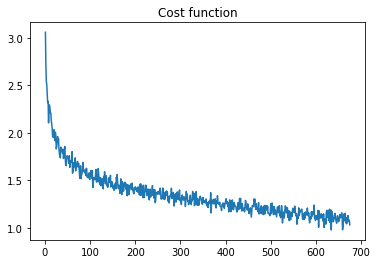

Error, Alpha parameter to lessen
1.0385110756955271
Error, Alpha parameter to lessen
1.1152179172689451
1.0736476875594243
Error, Alpha parameter to lessen
1.08070561489625
Error, Alpha parameter to lessen
1.0813846428630607
1.0454897597761095
Error, Alpha parameter to lessen
1.0547056347702222
Error, Alpha parameter to lessen
1.065255649569215
Error, Alpha parameter to lessen
1.078173833501298
1.05609744146707
1.0028229105996815
Error, Alpha parameter to lessen
1.1665386221527332
1.0934163147085718
Error, Alpha parameter to lessen
1.0971380095331253
1.080394912298681


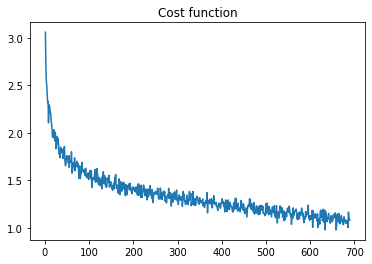

1.0501345160576525
1.0400879507193466
1.0076937090652318
Error, Alpha parameter to lessen
1.0541849433937172
Error, Alpha parameter to lessen
1.1267299763494039
1.1206653701099805
1.0442653302320903
Error, Alpha parameter to lessen
1.0676711729360364
1.0598493112671459
1.0499748601604952
Error, Alpha parameter to lessen
1.1148953727530047
1.0518935002635432
Error, Alpha parameter to lessen
1.0606448465874019
Error, Alpha parameter to lessen
1.0981071647260687
1.0850111426723672


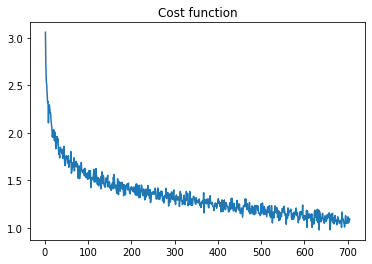

1.0653920828773447
1.0391650183779673
Error, Alpha parameter to lessen
1.0408482797023153
1.0354870759351378
Error, Alpha parameter to lessen
1.0590973062756184
0.9960845343444575
Error, Alpha parameter to lessen
1.0693498225517375
1.0581466238891597
Error, Alpha parameter to lessen
1.112688671739896
1.0297474946304506
1.0296337593428133
Error, Alpha parameter to lessen
1.0578721879064255
1.024234932991588
Error, Alpha parameter to lessen
1.1067366946202915
Error, Alpha parameter to lessen
1.1247948381924888


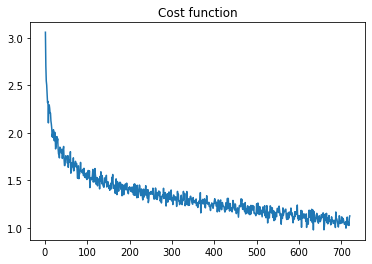

1.0743054995036478
1.0019380402599434
Error, Alpha parameter to lessen
1.021638610671044
Error, Alpha parameter to lessen
1.0528467637401144
Error, Alpha parameter to lessen
1.0889704420115813
Error, Alpha parameter to lessen
1.0958065738224065
Error, Alpha parameter to lessen
1.1189606365236313
1.0854406372240795
0.9623198337028455
Error, Alpha parameter to lessen
1.0106508438335886
Error, Alpha parameter to lessen
1.084828727489949
1.0583341449571508
1.0237985510229188
Error, Alpha parameter to lessen
1.0378605663388383
1.0075758402136459


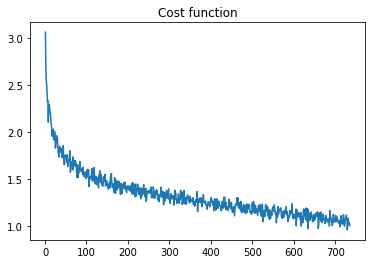

0.9189089657534092
Error, Alpha parameter to lessen
1.0360922190983592
Error, Alpha parameter to lessen
1.0973154335258812
1.0200025436160953
Error, Alpha parameter to lessen
1.0572427553862769
Error, Alpha parameter to lessen
1.0720445392434217
1.0189128593418515
Error, Alpha parameter to lessen
1.0955269299417825
1.0390228878261742
0.9833979463236697
Error, Alpha parameter to lessen
1.0452723696552133
1.0395245426899764
Error, Alpha parameter to lessen
1.0470635267535824
Error, Alpha parameter to lessen
1.0979917694349712
1.046510744733716


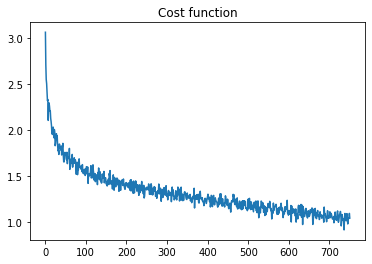

0.9671002031696022
Error, Alpha parameter to lessen
1.0607236528442316
Error, Alpha parameter to lessen
1.0886024123892293
1.0050717554443198
0.9712764213987128
Error, Alpha parameter to lessen
1.0240116086867337
1.0116834838835087
Error, Alpha parameter to lessen
1.1152484282600517
1.0289779690585894
Error, Alpha parameter to lessen
1.0417915509834976
1.0070529564033597
Error, Alpha parameter to lessen
1.0163303690485233
Error, Alpha parameter to lessen
1.0241089662990839
Error, Alpha parameter to lessen
1.0589799356448966
1.015751171866996


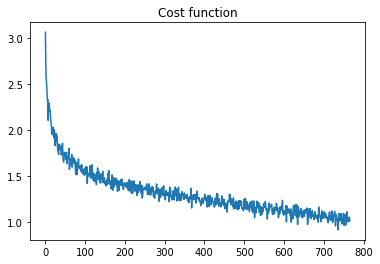

0.994108503356692
Error, Alpha parameter to lessen
1.0359507778671782
Error, Alpha parameter to lessen
1.1179880460973033
0.9975975199278144
Error, Alpha parameter to lessen
1.0252068223847286
0.9640466262132763
Error, Alpha parameter to lessen
1.046865611041642
1.0275027452982928
Error, Alpha parameter to lessen
1.0313601472238516
1.031017428816213
Error, Alpha parameter to lessen
1.0481846421494356
1.032966322483131
1.0243231112501068
0.9860481428700806
Error, Alpha parameter to lessen
1.0752405996653487


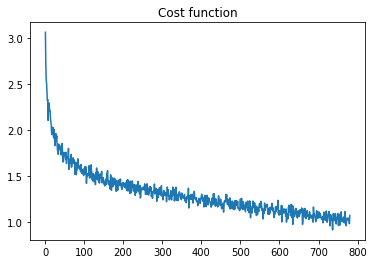

0.9301918439102841
Error, Alpha parameter to lessen
1.0685940333416095
0.9444589052007055
Error, Alpha parameter to lessen
1.032872541083003
1.0072299103647235
Error, Alpha parameter to lessen
1.022862869389059
0.9814323177582185
Error, Alpha parameter to lessen
1.0716388396306444
0.9981629583744638
Error, Alpha parameter to lessen
1.018072236691999
Error, Alpha parameter to lessen
1.065013892835262
1.0068673907034014
0.9901862833027891
Error, Alpha parameter to lessen
1.0296922783377553
1.0192981249252206


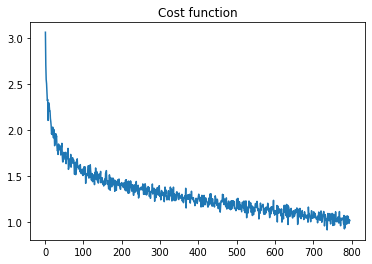

0.9610103258061743
Error, Alpha parameter to lessen
1.0388143818803617
0.9550912540746966
Error, Alpha parameter to lessen
1.0152950349767753
0.9671933265557657
Error, Alpha parameter to lessen
1.007784487103986
Error, Alpha parameter to lessen
1.0282668740375382
1.0144330498052487
Error, Alpha parameter to lessen
1.0261716655204214
0.9592186073226632
Error, Alpha parameter to lessen
0.9996995626796504
Error, Alpha parameter to lessen
1.058751007820545
0.9651988279734725
Error, Alpha parameter to lessen
1.0685020396774982
1.0358178051348594


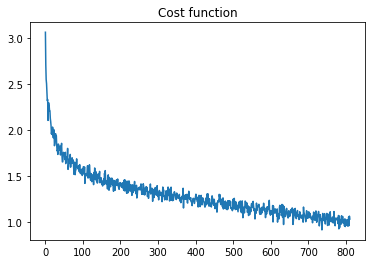

1.0124560186331157
0.943348011531383
Error, Alpha parameter to lessen
0.9969329444047021
0.9912145893425034
Error, Alpha parameter to lessen
0.9977793527969339
Error, Alpha parameter to lessen
1.0119335356980472
Error, Alpha parameter to lessen
1.022781900345893
0.9845056431410613
0.94457414943614
Error, Alpha parameter to lessen
0.9827372994498339
Error, Alpha parameter to lessen
1.0479381533668957
1.025817166982092
1.0224897050298496
Error, Alpha parameter to lessen
1.0341285267894824
0.9993953832668814


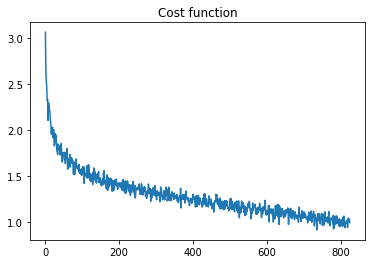

0.9512322067827337
Error, Alpha parameter to lessen
0.9790009659337032
Error, Alpha parameter to lessen
0.9824147925564074
Error, Alpha parameter to lessen
1.0003719914263938
Error, Alpha parameter to lessen
1.0506988877700343
0.9473859438694009
Error, Alpha parameter to lessen
0.9952040962172479
0.9863237744735988
Error, Alpha parameter to lessen
1.010558864808945
0.9922205755398069
0.9620204850350741
Error, Alpha parameter to lessen
1.0407437650588758
0.927357168134544
Error, Alpha parameter to lessen
1.0374819905756718
1.014375787598932


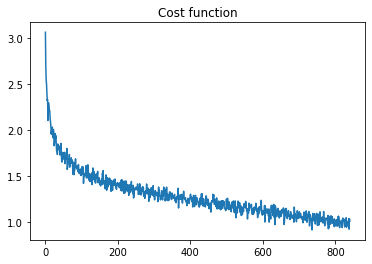

0.9141281562331376
Error, Alpha parameter to lessen
0.9754329430603952
Error, Alpha parameter to lessen
1.0011647061128233
0.9742973165881181
Error, Alpha parameter to lessen
1.0075988265517062
0.9621300934035546
Error, Alpha parameter to lessen
0.9707514836122437
Error, Alpha parameter to lessen
0.9760101354783779
Error, Alpha parameter to lessen
0.9997157566491999
0.9951093432729113
0.9604349893469903
Error, Alpha parameter to lessen
0.97975053091802
Error, Alpha parameter to lessen
1.0477820772848496
0.9437171494731393
Error, Alpha parameter to lessen
1.0526593404538536


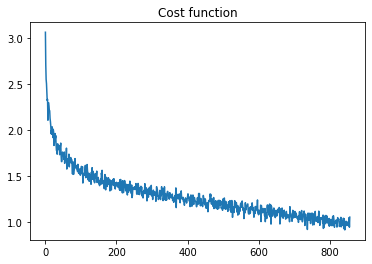

0.9438608898193059
Error, Alpha parameter to lessen
0.9882460296721477
0.9767573285834675
Error, Alpha parameter to lessen
1.0458824743414166
0.9778562026943356
Error, Alpha parameter to lessen
1.0398050700300836
0.9475514187937055
Error, Alpha parameter to lessen
0.9867343215866156
0.9769951084358545
Error, Alpha parameter to lessen
0.9950984738029459
0.9873723591833563
0.9572824781383413
0.8954475846310406
Error, Alpha parameter to lessen
0.9481971719654959
Error, Alpha parameter to lessen
1.0195428847235302


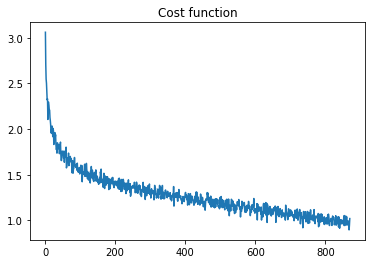

0.9212463904030768
Error, Alpha parameter to lessen
0.9235930979206762
Error, Alpha parameter to lessen
0.9293324760570886
Error, Alpha parameter to lessen
0.9638493207645543
0.951191402710354
Error, Alpha parameter to lessen
0.9754971908195964
Error, Alpha parameter to lessen
1.0108980374725394
0.984680589054954
0.9285082791245517
Error, Alpha parameter to lessen
1.002693671640478
0.9966665943970119
0.9840215482798151
Error, Alpha parameter to lessen
0.9936729077201408
Error, Alpha parameter to lessen
1.0209651045119754
0.9610334952530406


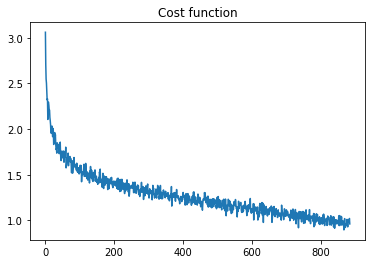

0.9311185982427329
Error, Alpha parameter to lessen
1.033659352020943
0.8844312352449148
Error, Alpha parameter to lessen
0.9185057015833427
Error, Alpha parameter to lessen
0.9719903860678611
Error, Alpha parameter to lessen
1.013287941164645
Error, Alpha parameter to lessen
1.0334926784883587
0.9478224508212818
0.8671109137597961
Error, Alpha parameter to lessen
0.9699165347931131
0.9391930981443755
Error, Alpha parameter to lessen
1.0286866206155458
0.9701481224571404
Error, Alpha parameter to lessen
0.9806068777033582
Error, Alpha parameter to lessen
0.9867208354018362


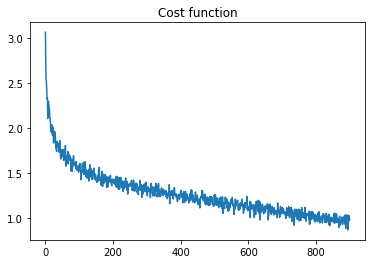

0.9240819603231215
Error, Alpha parameter to lessen
0.9771036430827221
0.8990353631479846
Error, Alpha parameter to lessen
0.9493123280242026
Error, Alpha parameter to lessen
0.9921723165742657
0.9626069119388235
0.8907167138117902
Error, Alpha parameter to lessen
1.0035502949196564
0.9918511906605308
0.9607363915618672
Error, Alpha parameter to lessen
1.0402615996617257
0.9073877624468566
Error, Alpha parameter to lessen
0.9307980279128351
0.9120754005022731
Error, Alpha parameter to lessen
0.9334405967912229


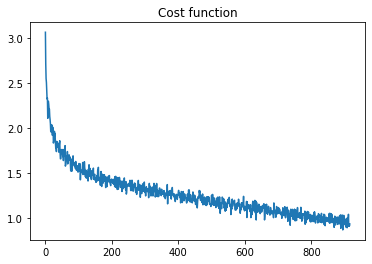

Error, Alpha parameter to lessen
0.935569815290353
0.9270184343517981
Error, Alpha parameter to lessen
0.9455936305089111
0.831510775664893
Error, Alpha parameter to lessen
0.967363048617931
0.9074027519420335
Error, Alpha parameter to lessen
1.009514237340154
0.953125543080572
Error, Alpha parameter to lessen
1.019610116118634
0.9275503154844029
Error, Alpha parameter to lessen
0.9426898173360485
Error, Alpha parameter to lessen
0.9550340105505771
Error, Alpha parameter to lessen
0.9718049510330523
Error, Alpha parameter to lessen
0.972460634089828
0.9398653379014523


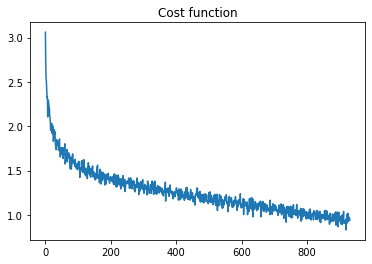

0.9116634961901487
0.8690156713807738
Error, Alpha parameter to lessen
0.9116851502487171
0.8794855014708481
Error, Alpha parameter to lessen
1.012193261883583
Error, Alpha parameter to lessen
1.0186624310932588
0.8976349031381772
Error, Alpha parameter to lessen
0.9885745410242863
0.9372990528628848
0.9087588265904795
Error, Alpha parameter to lessen
0.9735640615667744
0.9118714007340111
Error, Alpha parameter to lessen
0.9482107350283999
Error, Alpha parameter to lessen
0.9855673824449311
Error, Alpha parameter to lessen
1.0140986216749348


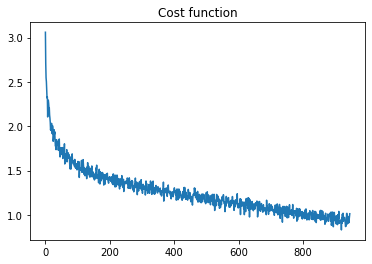

0.9182130629131103
0.9093240648708367
0.9092798554246335
Error, Alpha parameter to lessen
0.9347760159849514
Error, Alpha parameter to lessen
0.9543375690230108
0.8670342480741522
Error, Alpha parameter to lessen
0.9306017079022909
0.8979134056888022
Error, Alpha parameter to lessen
0.9282635251520944
Error, Alpha parameter to lessen
0.9758600493547542
Error, Alpha parameter to lessen
0.995501230863191
0.9549488947493898
0.9052659129429997
Error, Alpha parameter to lessen
0.9355411230374608
Error, Alpha parameter to lessen
0.9600812808541277


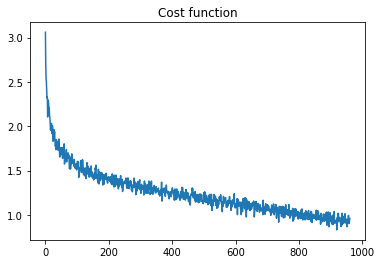

0.9429384122589827
Error, Alpha parameter to lessen
0.9515638382403434
Error, Alpha parameter to lessen
0.9635117882747796
0.9090114367794763
Error, Alpha parameter to lessen
0.9332394062058587
Error, Alpha parameter to lessen
0.9618464182089081
0.9115791007633736
0.8903103144354634
Error, Alpha parameter to lessen
0.9127968793196517
Error, Alpha parameter to lessen
0.9180992622180264
Error, Alpha parameter to lessen
0.950597514197029
0.911772717382626
Error, Alpha parameter to lessen
0.9371773044454474
0.8509579897767069
Error, Alpha parameter to lessen
0.9637603811159507


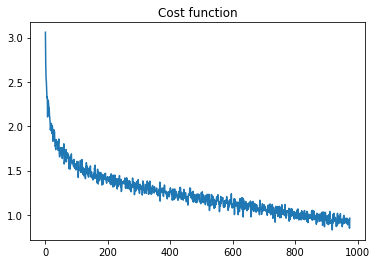

0.8768960142397979
0.849364375131972
Error, Alpha parameter to lessen
0.8822279286473539
0.8466256386649872
Error, Alpha parameter to lessen
0.9349275719464192
0.8759290618070873
Error, Alpha parameter to lessen
0.9900043496965121
0.9138478922399437
Error, Alpha parameter to lessen
0.9664663474081955
0.892352966270306
Error, Alpha parameter to lessen
0.9182418293447457
Error, Alpha parameter to lessen
0.9784766205077151
Error, Alpha parameter to lessen
0.9974176985275126
0.9288653582131893
0.8612609976624608


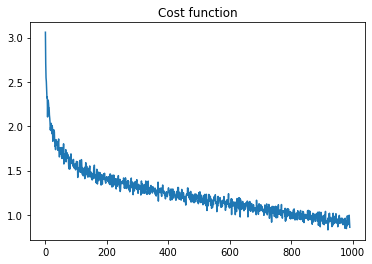

0.8514689970193886
Error, Alpha parameter to lessen
0.8891953116902404
0.8656966727498201
Error, Alpha parameter to lessen
0.9860828866474673
0.8675794816169616
Error, Alpha parameter to lessen
0.9129404880244121
Error, Alpha parameter to lessen
0.9446244965140751
0.9236878504459088
Error, Alpha parameter to lessen
0.9763532847955028
0.9090036075298834
Error, Alpha parameter to lessen
0.9518578192963905
0.8733137803743952
Error, Alpha parameter to lessen
0.909837956117123
Error, Alpha parameter to lessen
0.9200009995449134
Error, Alpha parameter to lessen
0.9292436516750907


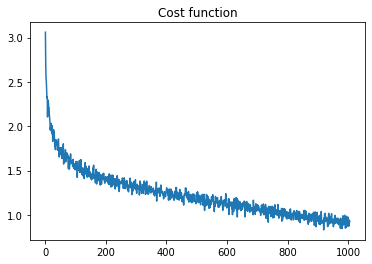

0.8836809537410232
Error, Alpha parameter to lessen
0.8945718792129349
Error, Alpha parameter to lessen
0.926374450106558
0.8877859373055749
Error, Alpha parameter to lessen
0.8907671357753977
Error, Alpha parameter to lessen
0.9077067722816434
0.9045756585455138
0.886022698210597
0.8761837141598935
Error, Alpha parameter to lessen
0.963689558818776
0.8695141756788709
Error, Alpha parameter to lessen
0.9002234661718808
Error, Alpha parameter to lessen
0.9642164496888213
0.9051311602931896
0.8642837491789365


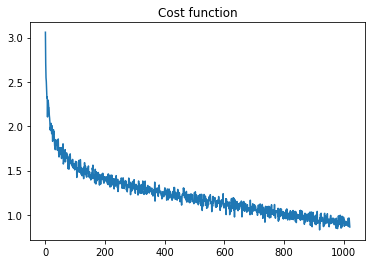

Error, Alpha parameter to lessen
0.9544581577108748
0.8824711168265217
0.8798820440508585
0.8605452997024766
Error, Alpha parameter to lessen
0.9148163971435458
0.851570950459061
Error, Alpha parameter to lessen
0.8866045988236795
Error, Alpha parameter to lessen
0.9247855534631442
Error, Alpha parameter to lessen
0.9541528962599557
0.8913902414730472
Error, Alpha parameter to lessen
0.9335607865101908
0.8925974580479191
0.8872294869181725
Error, Alpha parameter to lessen
0.9293520821240989
0.8684969307084688


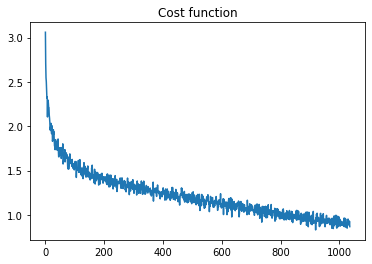

Error, Alpha parameter to lessen
0.905563706777125
0.8645394874890105
Error, Alpha parameter to lessen
0.8999234905317015
0.8314544316124741
Error, Alpha parameter to lessen
0.8572266352526275
Error, Alpha parameter to lessen
0.8634717326614054
Error, Alpha parameter to lessen
1.0017868949924973
0.8833421362833777
Error, Alpha parameter to lessen
0.8907824891152287
Error, Alpha parameter to lessen
0.9087171183206277
0.8523449815342198
Error, Alpha parameter to lessen
0.8755541673844199
0.8483180878018238
Error, Alpha parameter to lessen
0.9494594603352098
0.9002922781477458


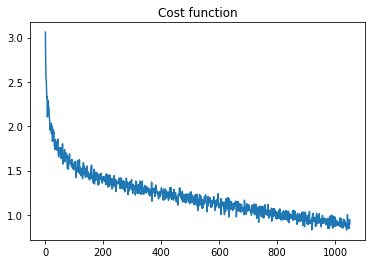

0.8564724040366902
Error, Alpha parameter to lessen
0.9144696293041474
0.8525113473705079
0.850302846737811
0.8240696104211931
Error, Alpha parameter to lessen
0.8833302826160229
Error, Alpha parameter to lessen
0.8858128532206728
Error, Alpha parameter to lessen
0.8925743546174055
0.8603859956643398
Error, Alpha parameter to lessen
0.9193076653217408
0.8958834045788451
0.8720972080838276
Error, Alpha parameter to lessen
0.9561802833025792
0.9298546005105529
0.8597759440528189


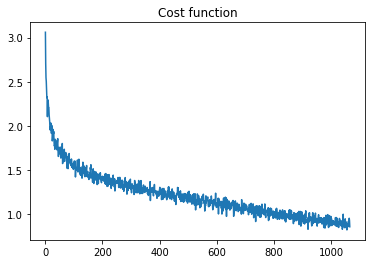

Error, Alpha parameter to lessen
0.8705535122114118
Error, Alpha parameter to lessen
0.8875915510368564
Error, Alpha parameter to lessen
0.8880623189051692
0.8853287908876382
0.7680944171974273
Error, Alpha parameter to lessen
0.8279893321433713
0.7821875543512569
Error, Alpha parameter to lessen
1.009902812973307
0.9293967531164851
0.854530414602459
Error, Alpha parameter to lessen
0.8778675529853356
0.7954074637643753
Error, Alpha parameter to lessen
0.9276805286426805
0.8886566927882938
0.8850843121424152


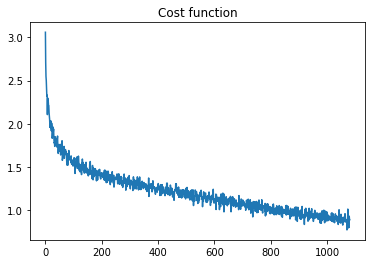

0.8620689453630916
0.8494382118013154
0.8459121302607389
Error, Alpha parameter to lessen
0.864259979519219
Error, Alpha parameter to lessen
0.8968388269494453
0.7951846701338654
Error, Alpha parameter to lessen
0.9362842940874306
0.7936646147300003
Error, Alpha parameter to lessen
0.8538932089391944
Error, Alpha parameter to lessen
0.8830807536727895
Error, Alpha parameter to lessen
0.8913580583755638
0.8185169579900655
Error, Alpha parameter to lessen
0.8915138577960094
Error, Alpha parameter to lessen
0.9095677986749967
0.8895299832880714


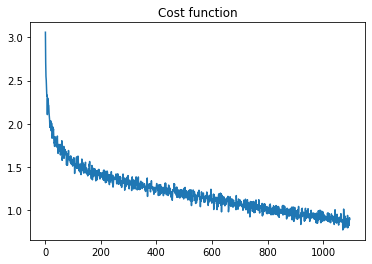

0.8517234902615318
Error, Alpha parameter to lessen
0.8948154546766804
0.8173290118617981
Error, Alpha parameter to lessen
0.8984827604769487
0.807947877599883
Error, Alpha parameter to lessen
0.8592977605019985
0.8545857634331997
Error, Alpha parameter to lessen
0.8618087091145132
Error, Alpha parameter to lessen
0.8703933777388204
0.8634949214399902
0.8435505071932867
Error, Alpha parameter to lessen
0.8671989150510674
0.8395884842950623
Error, Alpha parameter to lessen
0.8848955117516532
0.8531459959711664


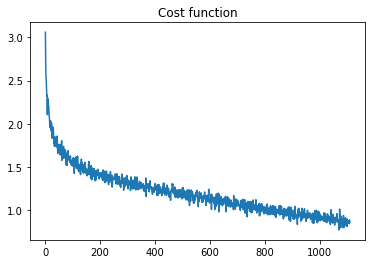

0.8429882011283953
0.825710710776475
Error, Alpha parameter to lessen
0.8428905482174127
0.8320070317265694
Error, Alpha parameter to lessen
0.8769119187211012
0.858694545447708
0.8501014062372765
0.8104208646794084
0.8023267372649012
Error, Alpha parameter to lessen
0.9191861755585756
0.9087493679153189
0.8838769484116412
0.88320269263538
0.8526151064073308
0.8337134793490758


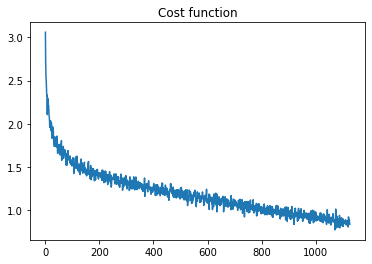

0.8245191555320187
Error, Alpha parameter to lessen
0.8659863393563256
Error, Alpha parameter to lessen
0.8897748198002969
0.7769033825735863
Error, Alpha parameter to lessen
0.8240040939342641
Error, Alpha parameter to lessen
0.8497486767994861
Error, Alpha parameter to lessen
0.9137549442576182
0.8553105225330166
0.8370574612805304
0.8308015236708904
Error, Alpha parameter to lessen
0.8334004543450908
Error, Alpha parameter to lessen
0.8889722618148488
0.8202186315602111
Error, Alpha parameter to lessen
0.8276205063567921
Error, Alpha parameter to lessen
0.8644337573461567


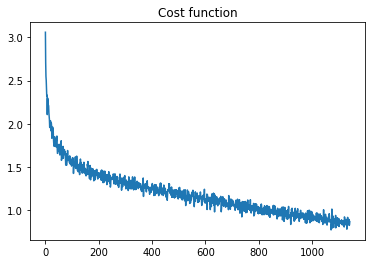

0.7905120849000593
Error, Alpha parameter to lessen
0.8253242697904403
Error, Alpha parameter to lessen
0.8638660743892963
0.8057907561231759
Error, Alpha parameter to lessen
0.8706756438746568
0.8253562112039162
0.8101772866104692
0.7988259221194048
Error, Alpha parameter to lessen
0.8525000460028316
0.8123032463123876
Error, Alpha parameter to lessen
0.8864673958943459
0.8634489080090495
0.8554238629453129
Error, Alpha parameter to lessen
0.9368412823421828
0.8331052854775731


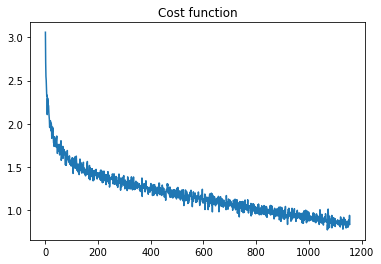

0.7976168051390538
Error, Alpha parameter to lessen
0.8533072203447349
0.775246447756033
Error, Alpha parameter to lessen
0.7899687429192918
Error, Alpha parameter to lessen
0.7900951681803312
Error, Alpha parameter to lessen
0.9021828792841297
0.8103829393039192
Error, Alpha parameter to lessen
0.8156397890218413
Error, Alpha parameter to lessen
0.8697654318973229
0.8258649140875969
Error, Alpha parameter to lessen
0.8887482807231322
0.8182156311706089
Error, Alpha parameter to lessen
0.8514382273440654
Error, Alpha parameter to lessen
0.870982778009656
0.8679080564651884


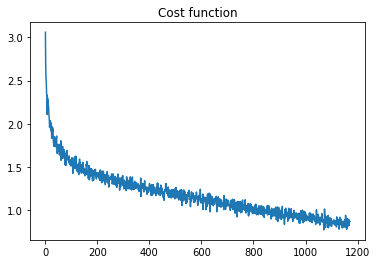

0.8027405992942391
0.7978186855054834
Error, Alpha parameter to lessen
0.8360006491747702
Error, Alpha parameter to lessen
0.8769091773675591
0.8136992530293765
Error, Alpha parameter to lessen
0.8636393227957326
0.8405809048318297
0.8019198266459413
Error, Alpha parameter to lessen
0.8231645650876241
Error, Alpha parameter to lessen
0.8694079791210382
0.8362737518452863
0.8219732851253689
0.8138387218709147
Error, Alpha parameter to lessen
0.8172835547513505
0.7870190726070951


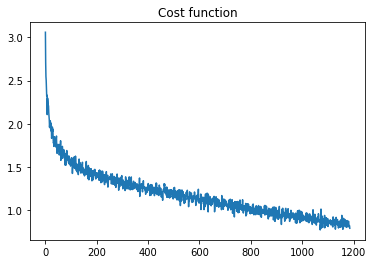

0.7552483798731174
Error, Alpha parameter to lessen
0.8311694600746331
0.8142818312687357
Error, Alpha parameter to lessen
0.8533583172442523
0.8457933505247217
0.8132092856530896
Error, Alpha parameter to lessen
0.8354383021432873
0.7997926767688132
Error, Alpha parameter to lessen
0.8217019932711397
0.8206472904070693
0.8051495930952737
Error, Alpha parameter to lessen
0.8136288865281263
Error, Alpha parameter to lessen
0.8477325182830461
Error, Alpha parameter to lessen
0.8491638717658044
0.8044861599534389


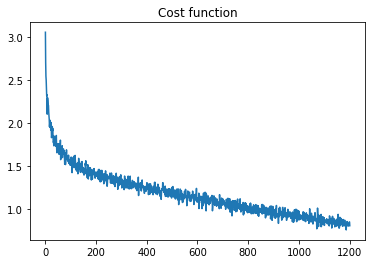

0.7776902415179032
Error, Alpha parameter to lessen
0.7847112799784678
Error, Alpha parameter to lessen
0.866539798113992
0.8188657030916777
0.7896493013474086
Error, Alpha parameter to lessen
0.8242231622887292
0.8224419794263718
Error, Alpha parameter to lessen
0.8519004452815969
0.8334921651178273
0.8178851077538253
Error, Alpha parameter to lessen
0.8322322930190529
0.7814765774550017
Error, Alpha parameter to lessen
0.8461863631868208
0.7690050570597506
Error, Alpha parameter to lessen
0.8016420492108661


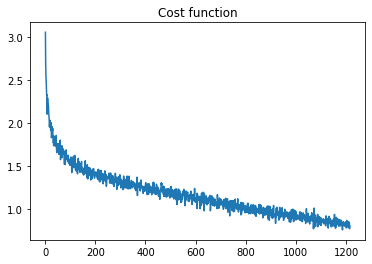

0.7896475536766425
0.7246884979079773
Error, Alpha parameter to lessen
0.7696621981199314
Error, Alpha parameter to lessen
0.7930551545980228
Error, Alpha parameter to lessen
0.8110171986016838
0.8073400907905269
Error, Alpha parameter to lessen
0.82337500977202
0.7946065211200837
0.7707174401433663
Error, Alpha parameter to lessen
0.7907177257432654
Error, Alpha parameter to lessen
0.8687769285399161
0.8164285338642725
Error, Alpha parameter to lessen
0.8683400426002668
Error, Alpha parameter to lessen
0.8721194885986026
0.8266328270056889


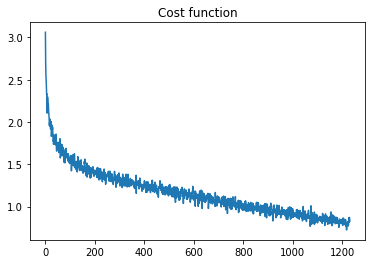

0.7386641376299375
0.7185655246379237
Error, Alpha parameter to lessen
0.7497406215464311
Error, Alpha parameter to lessen
0.7658769370238796
Error, Alpha parameter to lessen
0.7829364550443384
Error, Alpha parameter to lessen
0.8448164016163668
0.8276766494089038
Error, Alpha parameter to lessen
0.8291575059944326
0.7468314921740256
Error, Alpha parameter to lessen
0.887051693287693
0.8166567373660653
Error, Alpha parameter to lessen
0.8517233110620605
0.809256881090439
Error, Alpha parameter to lessen
0.8392949086866791
0.8158339583231806


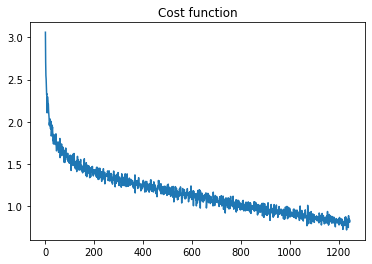

0.7794875288575258
0.7631980878599318
Error, Alpha parameter to lessen
0.7653103500029182
Error, Alpha parameter to lessen
0.8133879401855477
0.7570385784748752
Error, Alpha parameter to lessen
0.838069340755099
0.7587504426448513
Error, Alpha parameter to lessen
0.7808968587163405
0.7502926639174613
Error, Alpha parameter to lessen
0.7731718565765866
Error, Alpha parameter to lessen
0.902819663533774
0.7834317728718181
0.7327322446413097
Error, Alpha parameter to lessen
0.811214461470515
Error, Alpha parameter to lessen
0.8604047697999994


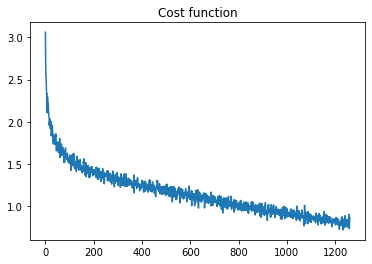

0.7197232686355622
Error, Alpha parameter to lessen
0.8114606924483501
0.7028147493952094
Error, Alpha parameter to lessen
0.7518262269385074
Error, Alpha parameter to lessen
0.8137459540357515
0.8062339937750612
Error, Alpha parameter to lessen
0.8549577857753198
0.8163012725404897
0.7890881026951521
Error, Alpha parameter to lessen
0.8656537039688702
0.7365223158534536
Error, Alpha parameter to lessen
0.8212103933248761
0.8158823602422364
0.7787832072973545
Error, Alpha parameter to lessen
0.7795217684497195


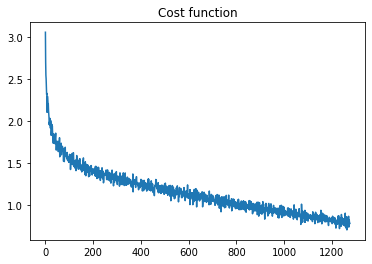

Error, Alpha parameter to lessen
0.7981402839584296
0.7864104805930203
0.7551901711615959
0.7357065968132798
Error, Alpha parameter to lessen
0.8512857733625179
0.7586387963887977
0.7556193456713127
Error, Alpha parameter to lessen
0.7739812495478168
Error, Alpha parameter to lessen
0.8170216483349209
0.764394177182908
0.7401645636079445
Error, Alpha parameter to lessen
0.8223699077578558
0.7783499908491442
Error, Alpha parameter to lessen
0.7874421510664623
0.7745934724775483


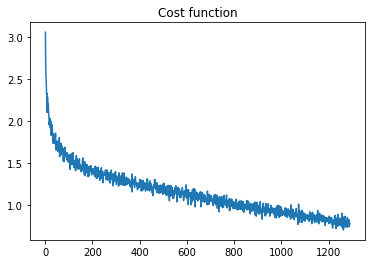

0.7231781471997974
Error, Alpha parameter to lessen
0.7633132307519249
0.7360843743925509
Error, Alpha parameter to lessen
0.7773525489053251
Error, Alpha parameter to lessen
0.8021904338501405
0.7846555471976508
Error, Alpha parameter to lessen
0.8002072940207637
0.7908260328065843
0.7880050926073274
0.7253858685504726
Error, Alpha parameter to lessen
0.818688474994357
0.7520644607325317
Error, Alpha parameter to lessen
0.788493142958254
Error, Alpha parameter to lessen
0.8283768114517549
0.8095797991880214


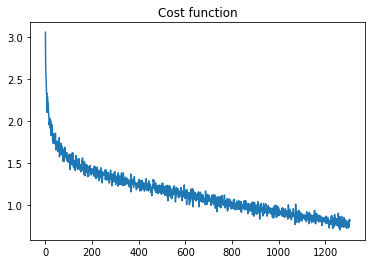

0.7198601477088121
Error, Alpha parameter to lessen
0.7259745490772244
Error, Alpha parameter to lessen
0.7310705516612186
Error, Alpha parameter to lessen
0.7753041306708444
Error, Alpha parameter to lessen
0.8101839888006108
0.7785043287682301
Error, Alpha parameter to lessen
0.790660218804069
0.74436368079136
Error, Alpha parameter to lessen
0.8130279967205502
0.7586388163858052
Error, Alpha parameter to lessen
0.7902625796163193
0.761065657926325
0.7469118016224351
Error, Alpha parameter to lessen
0.8072969872235118
Error, Alpha parameter to lessen
0.8471584117663615


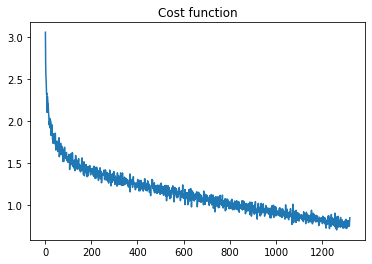

0.706031714296858
Error, Alpha parameter to lessen
0.7392952462751832
Error, Alpha parameter to lessen
0.7626983279598448
Error, Alpha parameter to lessen
0.8053862739531734
0.7838230360228231
0.7045380224061626
Error, Alpha parameter to lessen
0.7799651121689242
0.7300079341162813
Error, Alpha parameter to lessen
0.7477347629687655
Error, Alpha parameter to lessen
0.7651563995002767
Error, Alpha parameter to lessen
0.7738344451645188
0.7681623070586289
Error, Alpha parameter to lessen
0.7989532521125516
0.7725840871930791
0.744654091682363


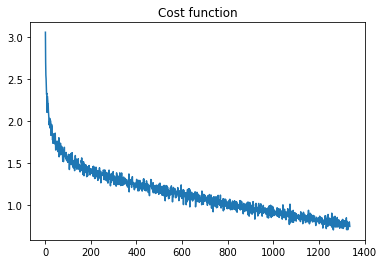

Error, Alpha parameter to lessen
0.7662998058444734
0.7104425476715015
Error, Alpha parameter to lessen
0.7355620285882034
0.704741408711159
0.7005420950558554
Error, Alpha parameter to lessen
0.7529562722150306
Error, Alpha parameter to lessen
0.8010671252187422
0.7356278875995723
Error, Alpha parameter to lessen
0.810833492207701
Error, Alpha parameter to lessen
0.8324269273703229
0.7969480923224507
0.7416016636089183
Error, Alpha parameter to lessen
0.7996479310092275
0.7504136616007078
Error, Alpha parameter to lessen
0.7739753828747886


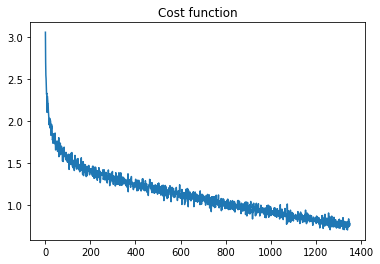

0.6683747208227332
Error, Alpha parameter to lessen
0.7220407455550952
Error, Alpha parameter to lessen
0.7327371339681957
0.7272748046485846
Error, Alpha parameter to lessen
0.8447220990647987
0.7567548973737072
0.7556140547348058
0.7354186487944525
0.7272966292639658
Error, Alpha parameter to lessen
0.7918258200540823
0.7226377008138356
Error, Alpha parameter to lessen
0.7825526709572248
0.7504110165675709
0.7439490541589953
Error, Alpha parameter to lessen
0.8144318071242567


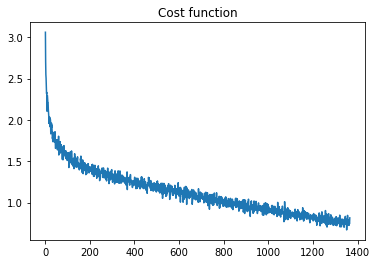

0.7013230822806797
Error, Alpha parameter to lessen
0.7576528864512566
0.7038898090591608
Error, Alpha parameter to lessen
0.7363839904688565
Error, Alpha parameter to lessen
0.7843154738886802
0.7075108624878759
Error, Alpha parameter to lessen
0.7542610935243576
0.731326459441774
Error, Alpha parameter to lessen
0.7342354859480981
0.7237390392726452
Error, Alpha parameter to lessen
0.7446506309563949
Error, Alpha parameter to lessen
0.7685721367551857
Error, Alpha parameter to lessen
0.7727839225457894
Error, Alpha parameter to lessen
0.7922562076914776
0.7474659018438979


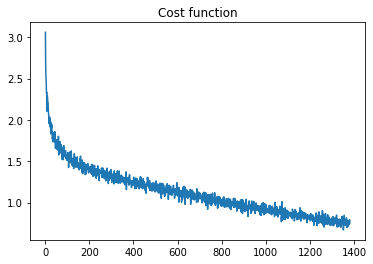

0.6502926377366502
Error, Alpha parameter to lessen
0.7284343410617741
0.7271981175194396
Error, Alpha parameter to lessen
0.7910335031639423
0.7255652319192013
Error, Alpha parameter to lessen
0.7765271861881181
0.7727225651030146
0.6813884516302263
Error, Alpha parameter to lessen
0.7106637686885848
Error, Alpha parameter to lessen
0.7560633329055749
0.7373943402938203
0.7238627226738577
Error, Alpha parameter to lessen
0.7362391257313701
Error, Alpha parameter to lessen
0.7874955279686096
0.7677135271490443


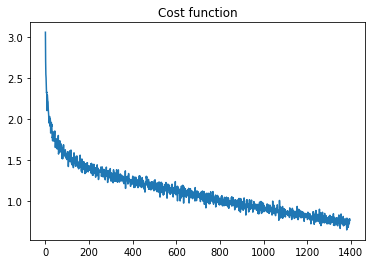

0.6917601533480549
0.6827941234946711
Error, Alpha parameter to lessen
0.7239376266046063
Error, Alpha parameter to lessen
0.7691611060203769
0.715048746996113
Error, Alpha parameter to lessen
0.7218006108033704
Error, Alpha parameter to lessen
0.784125314530741
0.7179248349358336
0.701516322841732
Error, Alpha parameter to lessen
0.7697710116963739
0.7389290816899301
Error, Alpha parameter to lessen
0.787076457992335
0.7213753304018347
Error, Alpha parameter to lessen
0.7581597769837725
0.7412868033538089


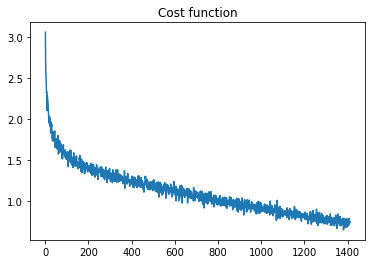

0.7180285159174525
0.6935628121622511
Error, Alpha parameter to lessen
0.7025038026377397
0.666826790203517
Error, Alpha parameter to lessen
0.6972750657979697
Error, Alpha parameter to lessen
0.7152781727062367
Error, Alpha parameter to lessen
0.7617765592424671
0.7156234878709914
Error, Alpha parameter to lessen
0.7870133014373724
0.6966605281030728
Error, Alpha parameter to lessen
0.7332639542439235
Error, Alpha parameter to lessen
0.7383477494567876
Error, Alpha parameter to lessen
0.7569179021809557
0.7478591326831335
Error, Alpha parameter to lessen
0.7909507368686681


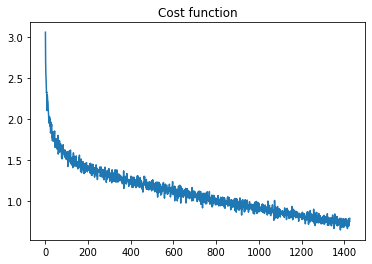

0.721582351536252
0.684740088071498
Error, Alpha parameter to lessen
0.7721119159032287
0.7440724321461506
Error, Alpha parameter to lessen
0.7524202961806056
0.7013981177269626
Error, Alpha parameter to lessen
0.724104156504359
Error, Alpha parameter to lessen
0.7342152538535047
0.7220392733685224
0.7137282364183952
0.6948129693909942
0.6779560551356675
Error, Alpha parameter to lessen
0.7309987014524546
0.7124201679648827
Error, Alpha parameter to lessen
0.7249463907038427


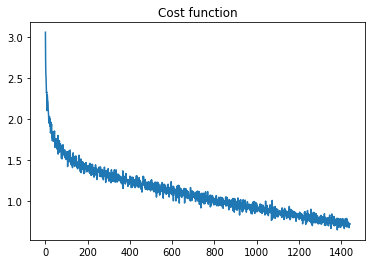

Error, Alpha parameter to lessen
0.7371887278913952
Error, Alpha parameter to lessen
0.7594607555399087
0.7221296994169035
0.6882824260096498
Error, Alpha parameter to lessen
0.7081903899909086
0.703214495790906
Error, Alpha parameter to lessen
0.7156172180624863
Error, Alpha parameter to lessen
0.7284157773886691
0.6948608911886816
Error, Alpha parameter to lessen
0.7289782126650258
0.7007291846489936
Error, Alpha parameter to lessen
0.7565970152898693
0.7228451442625209
0.7111278889579076
0.7007969125115058


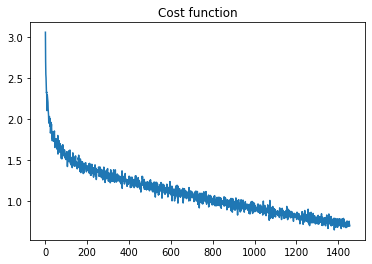

0.6941949401845824
Error, Alpha parameter to lessen
0.7139843331831118
0.6486312582282211
Error, Alpha parameter to lessen
0.6593269926412824
Error, Alpha parameter to lessen
0.7021874411204397
0.6709591717803199
Error, Alpha parameter to lessen
0.7461291602687975
0.7090176976658613
Error, Alpha parameter to lessen
0.7108864330252017
Error, Alpha parameter to lessen
0.7596855661858177
0.7269031117964271
0.6828734006426963
Error, Alpha parameter to lessen
0.743483421226175
0.7185011439127341
Error, Alpha parameter to lessen
0.7565726343240706


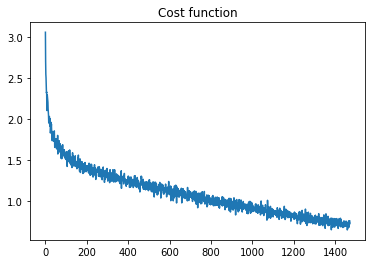

0.6689933470884137
0.6681621299024584
Error, Alpha parameter to lessen
0.6728661771924704
Error, Alpha parameter to lessen
0.7104706096717972
Error, Alpha parameter to lessen
0.7390807410853455
0.7136921599137797
0.6729717945668866
Error, Alpha parameter to lessen
0.7097191385291751
0.6800189841622791
Error, Alpha parameter to lessen
0.7642895208275284
0.6741520729397936
Error, Alpha parameter to lessen
0.7022632440658787
0.6825657855948165
Error, Alpha parameter to lessen
0.6836212292825664
Error, Alpha parameter to lessen
0.7701352528220994


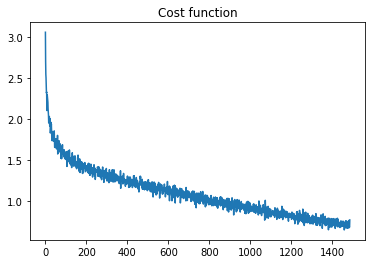

0.7072164273660126
0.6152507039750599
Error, Alpha parameter to lessen
0.6824918955334656
Error, Alpha parameter to lessen
0.7392931666173863
0.657962570488779
Error, Alpha parameter to lessen
0.670931213914721
Error, Alpha parameter to lessen
0.7048110770371464
0.6856161968872735
Error, Alpha parameter to lessen
0.6947573951184766
Error, Alpha parameter to lessen
0.7338786786078073
0.708295422851513
0.6992765122507563
Error, Alpha parameter to lessen
0.7508228448189422
0.7105866350615089
Error, Alpha parameter to lessen
0.7248811551506865


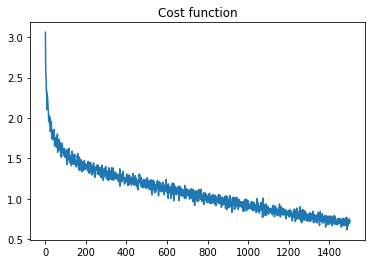

NN accuracy on training set 86.523%
NN accuracy on test set 40.000%


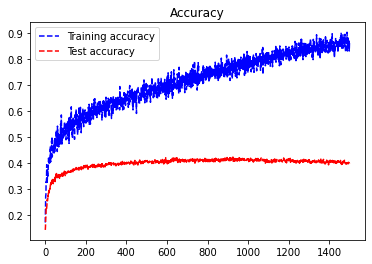

In [127]:
data, labels = read_cifar(short=True)
X_train, Y_train, X_test_clean, Y_test_clean = preprocessing(data,labels)
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [50, 30], N_epoch = 100, batch_size = 512, learning_rate= 0.0005, lambda_reg=0.1, 
              beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True)

Error, Alpha parameter to lessen
2.912345650553733
2.809648123225924
2.6111398737893947
2.569661981967437
2.42219260049089
2.389441525696242
2.2975300677459862
2.2229002163553417
2.2016303648031235
Error, Alpha parameter to lessen
2.2708887981047035
2.183464422000144
2.181851511076503
2.1661194421163517
2.0512281943341004
Error, Alpha parameter to lessen
2.056966609030386
Error, Alpha parameter to lessen
2.0790357769000094
Error, Alpha parameter to lessen
2.2100550274319315
2.0237946901865316
Error, Alpha parameter to lessen
2.0521994544900157
Error, Alpha parameter to lessen
2.0865337219098974
Error, Alpha parameter to lessen
2.090632076967145
1.9779350501079365
Error, Alpha parameter to lessen
2.144186564199066
2.0870892395610894
2.036899616792354
Error, Alpha parameter to lessen
2.0950858933643257
1.9775092725946408
Error, Alpha parameter to lessen
1.9957873659944978
Error, Alpha parameter to lessen
2.028065422496588
1.990821854503697
Error, Alpha parameter to lessen
2.0195794378343

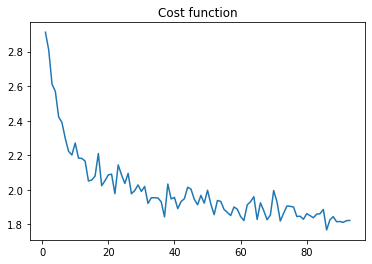

1.7522606360395994
1.7026455939978302
Error, Alpha parameter to lessen
1.7551003577376347
Error, Alpha parameter to lessen
1.819067268026483
1.7190547200286812
Error, Alpha parameter to lessen
1.8187502716742308
1.7894460212038197
1.6602455247579881
Error, Alpha parameter to lessen
1.7717876629873255
Error, Alpha parameter to lessen
1.8084065796008049
1.7482644067039825
1.7129317219276672
Error, Alpha parameter to lessen
1.7804117302332099
1.7208395767505082
Error, Alpha parameter to lessen
1.7236427035503572
1.693486856312165
1.6771372189343274
Error, Alpha parameter to lessen
1.755777605811607
1.7060355213376115
Error, Alpha parameter to lessen
1.7733898109739388
Error, Alpha parameter to lessen
1.8181769988353296
1.755490346610928
1.749360601419405
Error, Alpha parameter to lessen
1.7662106252190348
Error, Alpha parameter to lessen
1.8007175943411096
1.742837819111306
1.742666047573533
Error, Alpha parameter to lessen
1.7677200909485409
Error, Alpha parameter to lessen
1.76972990761

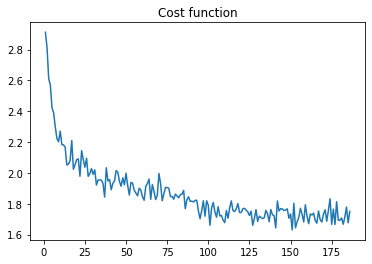

1.6954310729132283
1.6086497556327453
Error, Alpha parameter to lessen
1.6672375036418696
1.6357130647397526
Error, Alpha parameter to lessen
1.651701018304887
1.5953520172844102
Error, Alpha parameter to lessen
1.7199583862735783
1.6157095318143702
Error, Alpha parameter to lessen
1.6921728554576734
1.6754734851869304
1.6033310041425584
Error, Alpha parameter to lessen
1.6840590266753501
1.6432603270274841
Error, Alpha parameter to lessen
1.6562183234957173
Error, Alpha parameter to lessen
1.6683820928291793
1.6468609646436763
Error, Alpha parameter to lessen
1.6943504748084066
1.6419046151740546
Error, Alpha parameter to lessen
1.6878941084862833
1.6463654267144796
Error, Alpha parameter to lessen
1.7295221331661341
1.6217003815795077
1.595420255258823
Error, Alpha parameter to lessen
1.601066787000941
1.599781425696862
Error, Alpha parameter to lessen
1.761317588834416
1.650054471202896
Error, Alpha parameter to lessen
1.7089115690299916
1.6275275791898203
1.591543590125259
Error, A

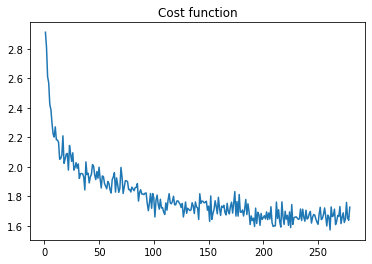

1.5322936489535923
Error, Alpha parameter to lessen
1.5700815204796896
Error, Alpha parameter to lessen
1.6097223078458767
1.583956800088236
1.517711713850262
Error, Alpha parameter to lessen
1.5906668412252043
Error, Alpha parameter to lessen
1.6348079943899052
Error, Alpha parameter to lessen
1.6760983677510028
Error, Alpha parameter to lessen
1.7109355582022354
Error, Alpha parameter to lessen
1.71370746706939
1.6670367005123876
1.5960155905958135
Error, Alpha parameter to lessen
1.612033843615356
Error, Alpha parameter to lessen
1.6437143144236235
Error, Alpha parameter to lessen
1.6589181219107827
Error, Alpha parameter to lessen
1.684502131810303
1.6241604907911387
Error, Alpha parameter to lessen
1.6569718888281149
1.589265079902203
Error, Alpha parameter to lessen
1.6026161687749008
Error, Alpha parameter to lessen
1.6219360733978847
1.618899107142433
1.5914983785835366
Error, Alpha parameter to lessen
1.6672022790028336
1.4863612529729608
Error, Alpha parameter to lessen
1.512

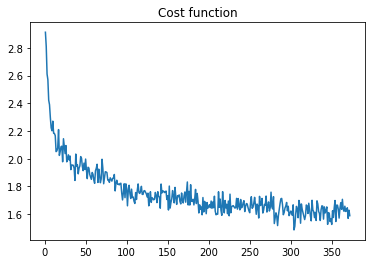

Error, Alpha parameter to lessen
1.6296376638769274
1.5378490241726939
Error, Alpha parameter to lessen
1.6469090236469133
1.5438513023106382
1.5414938091119799
Error, Alpha parameter to lessen
1.5744526785239297
1.4854858487157327
Error, Alpha parameter to lessen
1.7002497278299775
1.5591555982913903
1.5532707496256237
Error, Alpha parameter to lessen
1.5738828703293435
Error, Alpha parameter to lessen
1.5862557777791364
Error, Alpha parameter to lessen
1.681181013404033
1.6138329656045758
Error, Alpha parameter to lessen
1.6145083005383465
Error, Alpha parameter to lessen
1.6152646099216796
1.4862295940812391
Error, Alpha parameter to lessen
1.5345025792703941
Error, Alpha parameter to lessen
1.6263161026490898
1.6077165748065458
Error, Alpha parameter to lessen
1.6256613167654004
Error, Alpha parameter to lessen
1.63288093404779
1.622580374987552
1.5971394281481441
Error, Alpha parameter to lessen
1.598470451021385
1.5568217279002432
1.5055169257656786
Error, Alpha parameter to less

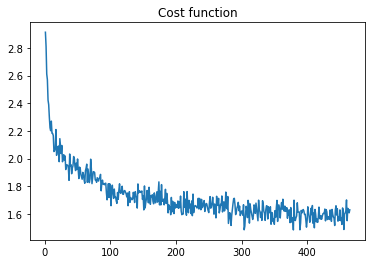

1.5635898062963518
1.5357402603736525
Error, Alpha parameter to lessen
1.5976007468589244
Error, Alpha parameter to lessen
1.5994831649657577
1.4717497424496133
Error, Alpha parameter to lessen
1.5890160883716287
1.5602241587944161
1.5442729478693904
Error, Alpha parameter to lessen
1.5975284709950526
1.5057578390796118
Error, Alpha parameter to lessen
1.5879754541555489
1.520305740769734
Error, Alpha parameter to lessen
1.6331683996368247
1.5153382261725852
Error, Alpha parameter to lessen
1.5968633738420237
1.593904045189813
1.5447375441448778
Error, Alpha parameter to lessen
1.5495068012390916
Error, Alpha parameter to lessen
1.6622095763748805
1.5865075329378195
1.5049988397891272
Error, Alpha parameter to lessen
1.6340695131544494
1.5770867251963339
1.511427109422256
Error, Alpha parameter to lessen
1.5472479375964823
1.5293297002352482
Error, Alpha parameter to lessen
1.6171488332571207
1.586416742646521
Error, Alpha parameter to lessen
1.5864604261438653
1.567373639522562
1.5441

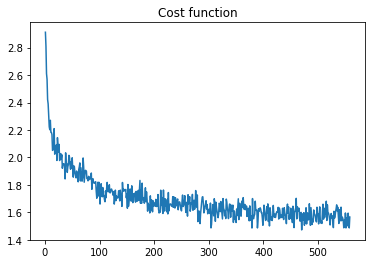

Error, Alpha parameter to lessen
1.6250009185483538
1.5562014387127927
1.5047598235768413
Error, Alpha parameter to lessen
1.5052529849837852
Error, Alpha parameter to lessen
1.5443014046604167
1.521796944826623
Error, Alpha parameter to lessen
1.5342631723677562
Error, Alpha parameter to lessen
1.5809042285799546
Error, Alpha parameter to lessen
1.5957471171756117
Error, Alpha parameter to lessen
1.6326127376103996
1.4461275134624854
Error, Alpha parameter to lessen
1.5862272599328129
1.5365432979327096
1.519298766344795
Error, Alpha parameter to lessen
1.6208019361701
1.5661651181154443
1.5394550682681045
1.4851214491739344
Error, Alpha parameter to lessen
1.5598683532444948
1.494826952648683
Error, Alpha parameter to lessen
1.5184657807119821
Error, Alpha parameter to lessen
1.5716926591189633
1.5115482522499186
Error, Alpha parameter to lessen
1.5429363029610996
1.4546778907743303
Error, Alpha parameter to lessen
1.6410215826301493
1.5117343797887846
Error, Alpha parameter to lesse

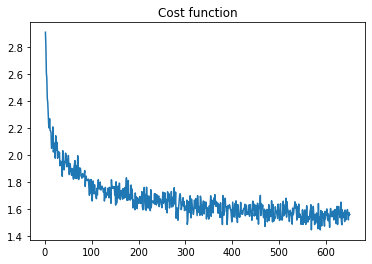

1.5519750763210465
1.541863336837023
1.522546685285059
Error, Alpha parameter to lessen
1.5578830842076479
Error, Alpha parameter to lessen
1.5768419660935313
1.4769253996174023
1.4233748948223517
Error, Alpha parameter to lessen
1.5729142322959329
Error, Alpha parameter to lessen
1.5788591371311882
1.5373231897422872
Error, Alpha parameter to lessen
1.5409146436458936
1.5188396746012518
Error, Alpha parameter to lessen
1.5836416129968451
1.5755723437988647
1.5504753703594363
Error, Alpha parameter to lessen
1.581780886553925
1.5553629057728986
1.456380759633511
Error, Alpha parameter to lessen
1.5071043218217848
Error, Alpha parameter to lessen
1.5348174886272465
Error, Alpha parameter to lessen
1.621614111301973
1.5905834661777334
1.4132690497433862
Error, Alpha parameter to lessen
1.5442300565222433
Error, Alpha parameter to lessen
1.6045615034241347
1.458460606991721
Error, Alpha parameter to lessen
1.49433974972487
Error, Alpha parameter to lessen
1.5545726976569156
1.496821581398

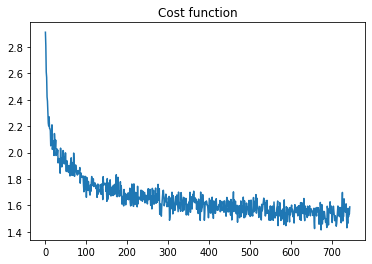

1.5108302201563588
1.485431791901552
Error, Alpha parameter to lessen
1.5327382348768959
Error, Alpha parameter to lessen
1.560431658886098
1.5519551607405275
1.5100083563412081
Error, Alpha parameter to lessen
1.5309020144797025
1.5232257266923328
1.4187271815178877
Error, Alpha parameter to lessen
1.5786843172569975
1.5686603500177931
Error, Alpha parameter to lessen
1.6073696288961596
1.5039537458704668
Error, Alpha parameter to lessen
1.5532922415494899
1.4985373882874846
Error, Alpha parameter to lessen
1.5046512965039516
Error, Alpha parameter to lessen
1.5518899537923718
1.4857159547084842
Error, Alpha parameter to lessen
1.4868829377828159
Error, Alpha parameter to lessen
1.5855507705743477
1.5373650400802084
1.5186858932955638
1.4766601348107058
Error, Alpha parameter to lessen
1.5194940135042783
1.513165259223124
1.4849309861472515
Error, Alpha parameter to lessen
1.5140578798368451
1.5004146593484633
Error, Alpha parameter to lessen
1.5065333483135201
1.4662331409317362
Erro

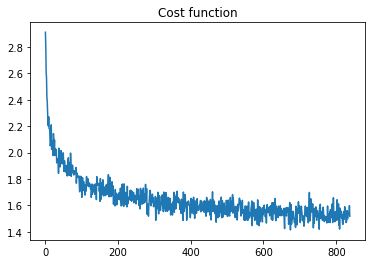

Error, Alpha parameter to lessen
1.5229263105220738
1.490862253184811
Error, Alpha parameter to lessen
1.547063015889084
1.3937430469531866
Error, Alpha parameter to lessen
1.4684039333043903
Error, Alpha parameter to lessen
1.4881733774187922
Error, Alpha parameter to lessen
1.531636561441922
Error, Alpha parameter to lessen
1.6129623678395244
1.4636736898503133
Error, Alpha parameter to lessen
1.516554401996814
1.5041165974347237
Error, Alpha parameter to lessen
1.529820301588678
1.4965385525398447
Error, Alpha parameter to lessen
1.5327517098855712
1.49180999270393
Error, Alpha parameter to lessen
1.5359912884502092
1.4383742996165148
Error, Alpha parameter to lessen
1.529750450222274
Error, Alpha parameter to lessen
1.5761865747596824
1.5646411292126503
1.5197624472928015
Error, Alpha parameter to lessen
1.5560385969204173
Error, Alpha parameter to lessen
1.5837060699330199
1.5172720726934696
1.488988338943821
1.4351388455753566
Error, Alpha parameter to lessen
1.5429271595347354
E

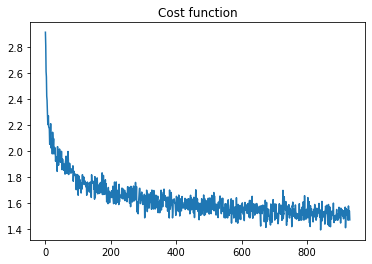

1.418727104590355
Error, Alpha parameter to lessen
1.486943863369569
Error, Alpha parameter to lessen
1.5262115315854543
Error, Alpha parameter to lessen
1.545666792443578
1.4863491794445267
Error, Alpha parameter to lessen
1.490776134205734
Error, Alpha parameter to lessen
1.5212920645696508
1.497543297547322
Error, Alpha parameter to lessen
1.5756504199437924
1.4921972338929856
1.4633953299847924
1.44539835216495
1.442139821222131
1.4141536900818537
Error, Alpha parameter to lessen
1.4825295050989695
1.477761958624077
Error, Alpha parameter to lessen
1.5022327873507302
Error, Alpha parameter to lessen
1.5214229075272299
1.4809694915548937
Error, Alpha parameter to lessen
1.4953677385685402
Error, Alpha parameter to lessen
1.5301088128769493
1.5271903939222005
1.4605682273179417
Error, Alpha parameter to lessen
1.4742203267498017
Error, Alpha parameter to lessen
1.4953193114240309
1.4651366970344741
Error, Alpha parameter to lessen
1.5213768290638936
Error, Alpha parameter to lessen
1

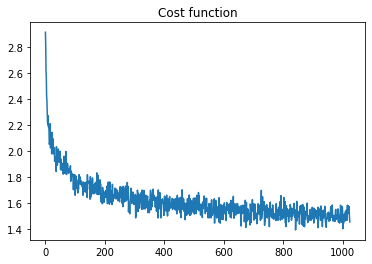

Error, Alpha parameter to lessen
1.5523962580619584
1.4456766172943032
Error, Alpha parameter to lessen
1.5074996717361508
Error, Alpha parameter to lessen
1.5765677510279545
1.4800435332594495
Error, Alpha parameter to lessen
1.4898839155436638
Error, Alpha parameter to lessen
1.496696201658194
Error, Alpha parameter to lessen
1.5302013722975183
1.4820847780021187
1.470696320326255
1.443368808550182
Error, Alpha parameter to lessen
1.4876437230284947
1.479746442259147
1.4222623803123597
Error, Alpha parameter to lessen
1.551906470689202
1.5380566507845548
Error, Alpha parameter to lessen
1.5705661949220882
1.4744933892092262
Error, Alpha parameter to lessen
1.5340761993816723
1.5015736658961771
1.4992029358673507
Error, Alpha parameter to lessen
1.5024116772236873
1.4513984536866567
Error, Alpha parameter to lessen
1.5211170084051961
1.4764316057613247
Error, Alpha parameter to lessen
1.5526001760233157
1.406760066895074
Error, Alpha parameter to lessen
1.5265875615935978
1.4439126359

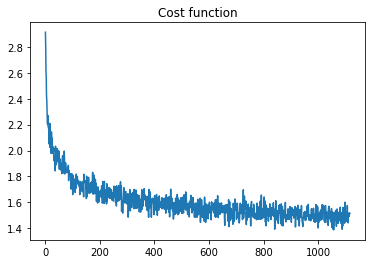

1.4516728923226068
1.4160725585124987
Error, Alpha parameter to lessen
1.531566860685132
1.4582147874168423
1.3868234068512661
Error, Alpha parameter to lessen
1.508600314489132
1.4680962050437492
Error, Alpha parameter to lessen
1.5587968074272938
1.4909549774654702
1.4876895921244309
Error, Alpha parameter to lessen
1.4995964318247372
1.4690736684223002
Error, Alpha parameter to lessen
1.4818414065065866
1.465278448844968
1.4624738717405543
Error, Alpha parameter to lessen
1.4899198632058546
Error, Alpha parameter to lessen
1.5121740212433672
1.499688556518629
Error, Alpha parameter to lessen
1.506697041993725
1.3683322929628312
Error, Alpha parameter to lessen
1.5377125367186664
1.418693350443698
Error, Alpha parameter to lessen
1.454218538824377
Error, Alpha parameter to lessen
1.5312331176594116
1.506916481083927
1.4762890484483429
Error, Alpha parameter to lessen
1.4841908731079123
1.463616266469809
Error, Alpha parameter to lessen
1.5392614245762195
1.5154326050777738
1.51529331

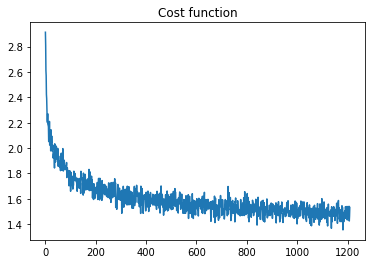

1.431480987366138
Error, Alpha parameter to lessen
1.4482216473959482
Error, Alpha parameter to lessen
1.5443417412691958
1.5369058490619767
1.4750528783365202
1.4424819906440332
1.378789936362949
Error, Alpha parameter to lessen
1.4300474315030711
Error, Alpha parameter to lessen
1.493172775512761
1.4557326678606572
Error, Alpha parameter to lessen
1.5149823331186631
1.4593724040261051
1.4246246114418541
Error, Alpha parameter to lessen
1.452227279094289
Error, Alpha parameter to lessen
1.5015742136800607
1.4975256702640767
1.4247917127702392
Error, Alpha parameter to lessen
1.4528177182132287
Error, Alpha parameter to lessen
1.4609919931333704
1.4255246589732022
Error, Alpha parameter to lessen
1.4859513552544066
Error, Alpha parameter to lessen
1.5387530553700346
Error, Alpha parameter to lessen
1.546696739579144
1.4447138747350237
Error, Alpha parameter to lessen
1.479452448606505
Error, Alpha parameter to lessen
1.5235675817264014
1.3928132821452386
Error, Alpha parameter to lesse

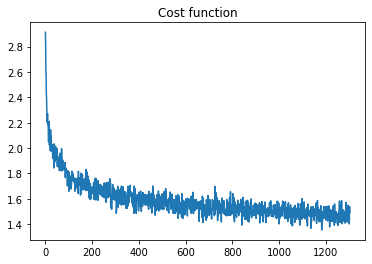

1.4708872679323486
Error, Alpha parameter to lessen
1.4902187699435492
1.4315633362100213
Error, Alpha parameter to lessen
1.5038500928366065
1.4203983716931323
Error, Alpha parameter to lessen
1.4424903886224982
Error, Alpha parameter to lessen
1.4689207738366374
1.4508977726528116
1.3822858226536938
Error, Alpha parameter to lessen
1.4251868451824563
1.3982262699886907
Error, Alpha parameter to lessen
1.4493336388763385
Error, Alpha parameter to lessen
1.482098543347666
1.4208112074984145
Error, Alpha parameter to lessen
1.4657867032022027
Error, Alpha parameter to lessen
1.5695372070433196
1.4745549975935368
1.435270871800416
Error, Alpha parameter to lessen
1.4432147148634349
1.4213775412041256
Error, Alpha parameter to lessen
1.4544426975779678
Error, Alpha parameter to lessen
1.4853445229001645
1.4480765101856605
1.444601610794687
1.4223212530211242
Error, Alpha parameter to lessen
1.432409528143488
Error, Alpha parameter to lessen
1.4740215273659183
Error, Alpha parameter to les

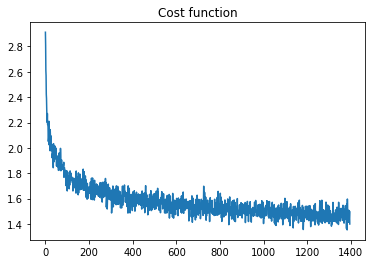

Error, Alpha parameter to lessen
1.4384695486817476
Error, Alpha parameter to lessen
1.5231782548291366
1.480399236325946
1.4303925272018352
Error, Alpha parameter to lessen
1.4486387097170201
1.3796901723352735
Error, Alpha parameter to lessen
1.4749497413725838
Error, Alpha parameter to lessen
1.4839496720368572
Error, Alpha parameter to lessen
1.514989477535278
1.3296356922857195
Error, Alpha parameter to lessen
1.412040954390171
Error, Alpha parameter to lessen
1.4478633705231254
1.436290212945855
1.4321921798224788
Error, Alpha parameter to lessen
1.514755077602592
1.4680232070043748
1.431434452565316
Error, Alpha parameter to lessen
1.4912013726621642
Error, Alpha parameter to lessen
1.5749206116653978
1.4297897001273798
Error, Alpha parameter to lessen
1.4402598335814654
Error, Alpha parameter to lessen
1.4527407867231898
Error, Alpha parameter to lessen
1.4871114989700618
1.428937387444717
Error, Alpha parameter to lessen
1.462835867140019
1.4222879337027803
Error, Alpha parame

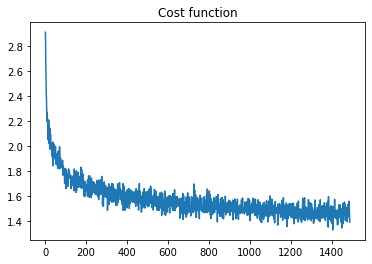

Error, Alpha parameter to lessen
1.421726873868141
1.3832376961750845
Error, Alpha parameter to lessen
1.5002364738959564
1.3336470899187876
Error, Alpha parameter to lessen
1.3911739276321793
Error, Alpha parameter to lessen
1.4641324628482053
Error, Alpha parameter to lessen
1.4998168233144764
1.4691446541107733
1.466749862439542
Error, Alpha parameter to lessen
1.4972448710055708
1.4034695536482569
Error, Alpha parameter to lessen
1.4780602342603903
1.471114495677092
Error, Alpha parameter to lessen
1.521764787111819
1.4624048428205438
Error, Alpha parameter to lessen
1.5222195664201041
1.3907644952713545
Error, Alpha parameter to lessen
1.4177888991551661
1.3744572931180157
Error, Alpha parameter to lessen
1.5050819374861095
1.3400145530054268
Error, Alpha parameter to lessen
1.43252586906615
Error, Alpha parameter to lessen
1.48408000862766
1.4008141771410183
Error, Alpha parameter to lessen
1.5268922663612976
Error, Alpha parameter to lessen
1.5368984764453761
1.508907659334502
1

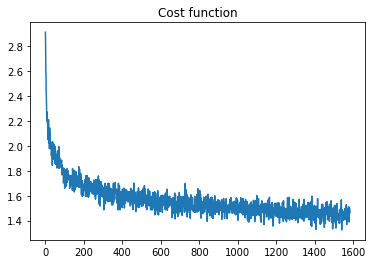

1.4941995646627748
1.399697811376541
Error, Alpha parameter to lessen
1.4253842283482687
1.3762277155386777
Error, Alpha parameter to lessen
1.4407586352048931
1.392508799539372
Error, Alpha parameter to lessen
1.405612109808414
Error, Alpha parameter to lessen
1.4450944229783116
1.4275804400628451
Error, Alpha parameter to lessen
1.5098204490382925
1.4013444447179986
Error, Alpha parameter to lessen
1.4822601112700742
1.4677877777835684
1.466081178010765
1.4625614188175924
1.44102572624893
1.409912751454159
Error, Alpha parameter to lessen
1.512758383516371
1.4898184834485333
1.4037884218856425
1.3788660998494044
Error, Alpha parameter to lessen
1.4658270584399453
1.4309345804703044
1.4132196139758302
Error, Alpha parameter to lessen
1.460012816677977
1.4101249910939582
Error, Alpha parameter to lessen
1.550232881476678
1.4824854660330122
1.4283380171901252
Error, Alpha parameter to lessen
1.5462569835595759
1.4123015742337417
Error, Alpha parameter to lessen
1.4653021956223051
1.3934

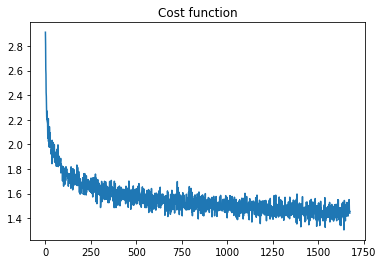

1.3984336872892247
Error, Alpha parameter to lessen
1.4397790114566102
Error, Alpha parameter to lessen
1.479367446263634
1.423348894370878
Error, Alpha parameter to lessen
1.499656963229369
1.387510891726778
1.3666314697142206
Error, Alpha parameter to lessen
1.564674691765092
1.4158407616462978
Error, Alpha parameter to lessen
1.499457560206834
1.4981415019370963
1.4407567385408633
Error, Alpha parameter to lessen
1.4585855410800932
1.444102787382328
1.4143743132226472
Error, Alpha parameter to lessen
1.4661005174832693
1.3841243479317307
Error, Alpha parameter to lessen
1.4114206179380537
Error, Alpha parameter to lessen
1.4293190587732205
1.3890949468503389
Error, Alpha parameter to lessen
1.469483180433341
1.4188940445107594
Error, Alpha parameter to lessen
1.5268627269232007
1.5098986833089907
1.367034659315725
Error, Alpha parameter to lessen
1.466428381953147
1.4283382128596938
Error, Alpha parameter to lessen
1.43797603292531
1.3913838640602014
1.3671342299804181
1.36416858820

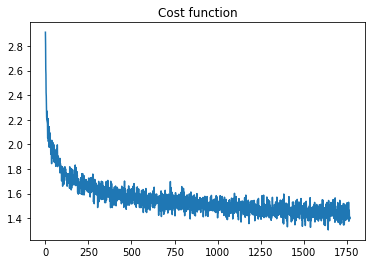

1.382350817078677
Error, Alpha parameter to lessen
1.4783245653135053
1.4391513203449937
1.4282208079750258
Error, Alpha parameter to lessen
1.471457433395804
Error, Alpha parameter to lessen
1.5087308375533384
1.4433249290665084
Error, Alpha parameter to lessen
1.5179512258021557
1.4538370810550398
Error, Alpha parameter to lessen
1.4802615450074736
Error, Alpha parameter to lessen
1.5106106433424435
1.4518241223522093
Error, Alpha parameter to lessen
1.4708159874297049
1.456882660667287
1.4339731580578619
1.4021446885657607
Error, Alpha parameter to lessen
1.4186336281940515
Error, Alpha parameter to lessen
1.4447070938610551
1.3908690717828904
Error, Alpha parameter to lessen
1.4540980167100996
1.3879819665246727
1.3569785982974751
Error, Alpha parameter to lessen
1.3704364980176673
Error, Alpha parameter to lessen
1.401154133944005
Error, Alpha parameter to lessen
1.460324879274843
1.4339230449256184
1.4082947990023023
Error, Alpha parameter to lessen
1.4554481557532797
1.454321494

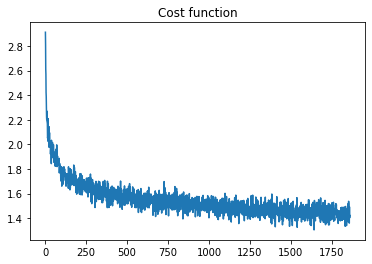

NN accuracy on training set 54.297%
NN accuracy on test set 46.292%


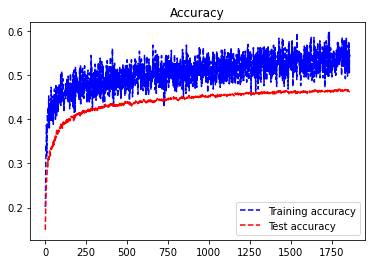

In [128]:
data, labels = read_cifar(short=False)
X_train, Y_train, X_test_clean, Y_test_clean = preprocessing(data,labels)
NN_model(X_train, Y_train, X_test_clean, Y_test_clean, hidden_layers= [50, 30], N_epoch = 20, batch_size = 512, learning_rate= 0.0005, lambda_reg=0.1, 
              beta1=0.9, beta2 = 0.999, learning_r_dec= True, adam=True)

In [118]:
for 

[10, 50, 30, 12]